## **Problem Statement**
Lending platforms face significant credit risk when issuing loans to borrowers. Without an effective risk assessment system, the company may experience financial losses due to high default rates. The dataset shows loans with "Charged Off" status that need to be anticipated from the outset to minimize portfolio risk.

## **Goal**
Develop a predictive model that can identify borrower default risk and classify them into risk tiers to support better lending decisions and optimize portfolio performance.

## **Objectives**

1. Understand the distribution and characteristics of borrowers, identify patterns and factors correlated with default risk, and analyze relationships between key variables such as income, DTI, credit history, and loan amount.

2. Build a predictive model to estimate default probability, perform feature engineering and selection, compare multiple algorithms, and optimize model performance through hyperparameter tuning.

3. Convert probability scores into actionable risk tiers with optimal thresholds based on risk appetite, and provide recommendations for each tier such as auto-approve, manual review, or reject.

4. Calculate potential loss rate reduction using the model, provide actionable insights for portfolio management, and create visualizations for ongoing risk monitoring.

## **0. Setup**

In [1]:
!pip install optuna

In [2]:
!pip install catboost

In [91]:
# STANDARD LIBRARY
import time
import json
import warnings
warnings.filterwarnings('ignore')

# DATA MANIPULATION & NUMERICAL
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

# VISUALIZATION
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns

# SKLEARN - BASE & UTILITIES
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# SKLEARN - PREPROCESSING
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder,
    StandardScaler, RobustScaler, MinMaxScaler,
    PowerTransformer, QuantileTransformer,
    FunctionTransformer
)

# SKLEARN - MODEL SELECTION & VALIDATION
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_val_score
)

# SKLEARN - FEATURE SELECTION
from sklearn.feature_selection import (
    SelectFromModel,
    VarianceThreshold
)

# SKLEARN - METRICS
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, average_precision_score,
    classification_report, confusion_matrix,
    log_loss, brier_score_loss,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

# SKLEARN - CLASSIFICATION MODELS
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, HistGradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

# GRADIENT BOOSTING LIBRARIES
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# IMBALANCED LEARNING
from imblearn.ensemble import BalancedRandomForestClassifier

# HYPERPARAMETER OPTIMIZATION
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# FILE MANAGEMENT & UTILITIES
import joblib
from google.colab import drive
import gc

# MODEL INTERPRETATION
import shap
import datetime

In [4]:
# MOUNT DRIVE
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!wget -q -O Poppins-Regular.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf
!wget -q -O Poppins-Bold.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf

fm.fontManager.addfont("Poppins-Regular.ttf")
fm.fontManager.addfont("Poppins-Bold.ttf")

mpl.rcParams['font.family'] = "Poppins"

In [6]:
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

mpl.rcParams['boxplot.boxprops.color'] = '#808080'
mpl.rcParams['boxplot.capprops.color'] = '#808080'
mpl.rcParams['boxplot.whiskerprops.color'] = '#808080'
mpl.rcParams['boxplot.medianprops.color'] = '#808080'
mpl.rcParams['boxplot.flierprops.color'] = '#808080'
mpl.rcParams['boxplot.meanprops.color'] = '#808080'

In [7]:
# Tampilkan semua kolom dan baris
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Jangan potong lebar kolom
pd.set_option('display.max_colwidth', None)

# Tampilkan lebih banyak karakter di satu baris
pd.set_option('display.width', None)

## **1. Data Loading**

In [8]:
# Load dataset and preview first rows
df = pd.read_csv(r"/content/drive/MyDrive/Rakamin/PBI/PBI November 2025/Dataset/loan_data_2007_2014.csv")
display(df.head())

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and f

In [9]:
# Show dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [10]:
# Show dataset size, memory usage, and data type summary
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nData Types Distribution:")
print(df.dtypes.value_counts())

Dataset Shape: 466,285 rows × 75 columns
Memory Usage: 779.95 MB

Data Types Distribution:
float64    46
object     22
int64       7
Name: count, dtype: int64


The dataset contains loan records from 2007 to 2014. Initial inspection reveals:

- **Dataset size**: The raw data includes numerous features capturing borrower information, loan characteristics, and payment history
- **Data types**: Mixed data types including numerical, categorical, and temporal features
- **Memory footprint**: Initial memory usage assessment helps identify potential optimization needs for large-scale processing

This stage establishes the foundation for subsequent preprocessing and ensures data accessibility for analysis.

## **2. Data Preprocessing**

### **2.0. Feature Engineering**

The target variable is created by categorizing loan status into binary outcomes (good vs bad loans). Several engineered features are added to capture risk-related patterns:

- **Temporal features**: Extract year, month, and quarter from issue dates to capture seasonality effects
- **Ratio features**: Calculate loan-to-income, payment-to-income, and credit utilization ratios to measure borrower capacity
- **Credit behavior metrics**: Derive account age, delinquency rates, and inquiry intensity to assess credit history quality
- **Categorical binning**: Group DTI and utilization into ranges for better interpretability

Target distribution shows class imbalance, with good loans significantly outnumbering bad loans, a typical characteristic in credit risk datasets.

In [11]:
# Feature engineering and ratio calculations for cleaner modeling
def safe_divide(numerator, denominator, fill_value=0):
    result = numerator / denominator
    result = result.replace([np.inf, -np.inf], fill_value)
    return result

emp_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
df['emp_length_cat'] = pd.Categorical(df['emp_length'], categories=emp_order, ordered=True)

dti_ranges = pd.cut(df['dti'], bins=[0, 5, 10, 15, 20, 25, 50], labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25+'])
df['dti_range'] = dti_ranges

df['earliest_cr_line_dt'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce', infer_datetime_format=True)
df['credit_history_years'] = (pd.to_datetime('2016-01-01') - df['earliest_cr_line_dt']).dt.days / 365.25

util_ranges = pd.cut(df['revol_util'], bins=[0, 20, 40, 60, 80, 100, 200], labels=['0-20', '20-40', '40-60', '60-80', '80-100', '100+'])
df['util_range'] = util_ranges

df['issue_d_dt'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df = df.dropna(subset=['issue_d_dt'])

df['issue_year'] = df['issue_d_dt'].dt.year
df['issue_month'] = df['issue_d_dt'].dt.month
df['issue_quarter'] = df['issue_d_dt'].dt.quarter

df['int_rate'] = (df['int_rate'].astype(str).str.replace('%', '', regex=False).astype(float))

df['loan_to_income'] = safe_divide(df['loan_amnt'], df['annual_inc'])
df['payment_to_income'] = safe_divide(df['installment'] * 12, df['annual_inc'])
df['credit_utilization'] = safe_divide(df['revol_bal'], df['total_rev_hi_lim'])
df['accounts_per_year'] = safe_divide(df['total_acc'], df['credit_history_years'])
df['avg_account_age'] = safe_divide(df['credit_history_years'], df['total_acc'])
df['delinq_rate'] = safe_divide(df['delinq_2yrs'], df['total_acc'])
df['inquiry_intensity'] = safe_divide(df['inq_last_6mths'], df['open_acc'])
df['funded_ratio'] = safe_divide(df['funded_amnt'], df['loan_amnt'])
df['annual_payment'] = df['installment'] * 12
df['revolving_income_ratio'] = safe_divide(df['revol_bal'], df['annual_inc'])
df['debt_burden'] = safe_divide(df['loan_amnt'] + df['revol_bal'], df['annual_inc'])

rare = ['OTHER', 'ANY', 'NONE']
df['home_ownership'] = df['home_ownership'].replace(rare, 'OTHER')

In [12]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')

latest_date = pd.to_datetime('2014-09-01')
cutoff_date = latest_date - pd.DateOffset(months=9)
mature_mask = (~df['loan_status'].isin(['Current', 'In Grace Period']) | (df['issue_d'] <= cutoff_date))

df = df[mature_mask].copy()

In [13]:
# Categorize loan outcomes
default_status = ['Charged Off',  'Default',  'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']
non_default_status = ['Fully Paid',  'Current', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid']

df['target'] = df['loan_status'].isin(default_status).astype(int)

# Check distribution
print("Distribution:")
print(df['target'].value_counts())
print("\nPercentage:")
print(df['target'].value_counts(normalize=True) * 100)

Distribution:
target
0    254701
1     50968
Name: count, dtype: int64

Percentage:
target
0    83.325754
1    16.674246
Name: proportion, dtype: float64


### **2.1. Drop Features**

Two categories of features are removed:

- **Leakage columns**: Features containing post-loan information (payments, recoveries, collection fees) that would not be available at prediction time
- **Irrelevant columns**: Identifiers, URLs, and redundant features that provide no predictive value

This reduces dimensionality while ensuring the model only uses information available at loan origination.

In [14]:
# Drop Leakage Columns
leakage_cols = ['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'funded_amnt_inv', '_rec']
leakage_dropped = [c for c in leakage_cols if c in df.columns]

df = df.drop(columns=leakage_cols, errors='ignore')
print(f"Dropped {len(leakage_dropped)} leakage columns")

Dropped 14 leakage columns


In [15]:
# Drop Irrelevant Columns
irrelevant_cols = ['Unnamed: 0', 'id', 'member_id', 'url', 'policy_code', 'emp_title', 'desc', 'title', 'issue_d_dt', 'zip_code', 'earliest_cr_line_dt', 'earliest_cr_line', 'issue_d', 'initial_list_status', 'loan_status', 'application_type']
irrelevant_dropped = [c for c in irrelevant_cols if c in df.columns]

df = df.drop(columns=irrelevant_cols, errors='ignore')
print(f"Dropped {len(irrelevant_dropped)} irrelevant columns")

Dropped 16 irrelevant columns


In [16]:
# Summary
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")

Number of columns: 66
Number of rows: 305669


### **2.2. Missing Values Handling**

Missing value analysis reveals:

- Columns with 100% missing values are dropped immediately
- High missing rate columns (>50%) are removed due to insufficient information
- Remaining missing values are handled through imputation strategies in the preprocessing pipeline

This approach balances information retention with data quality.

In [17]:
# Quick overview of missing values across all columns
missing_summary = (df.isnull().sum().reset_index().rename(columns={'index': 'column', 0: 'missing_count'}))
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(df)) * 100
missing_summary = missing_summary.sort_values(by='missing_pct', ascending=False)
display(missing_summary[missing_summary['missing_pct'] > 0])

,column,missing_count,missing_pct
27,dti_joint,305669,100.000000
32,open_acc_6m,305669,100.000000
46,inq_last_12m,305669,100.000000
40,open_rv_24m,305669,100.000000
28,verification_status_joint,305669,100.000000
26,annual_inc_joint,305669,100.000000
33,open_il_6m,305669,100.000000
45,total_cu_tl,305669,100.000000
44,inq_fi,305669,100.000000
42,all_util,305669,100.000000


In [18]:
# Drop columns with 100% missing values
threshold = 1.0
cols_100_missing = df.columns[df.isnull().sum() / len(df) == threshold]
df = df.drop(columns=cols_100_missing)

# Drop columns with high missing percentage (>50%)
threshold = 0.5
missing_pct = df.isnull().sum() / len(df)
high_missing_cols = missing_pct[missing_pct > threshold].index
df = df.drop(columns=high_missing_cols)

print(f"Columns remaining: {df.shape[1]}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

Columns remaining: 46
Remaining missing values: 710413


### **2.3. Outlier Handling Based on Domain Knowledge**

Domain-specific constraints are applied to detect impossible values:

- **Revol_util & credit_utilization**: Capped at 100% (utilization cannot exceed credit limit)
- **Credit_history_years**: Negative values corrected to zero
- **DTI**: Extreme values (>100%) capped at 60% based on industry standards

This ensures data validity without aggressive outlier removal that could eliminate legitimate edge cases.

In [19]:
# Basic descriptive stats for key numeric features
numeric_cols = ['loan_amnt', 'dti', 'revol_util', 'loan_to_income', 'credit_utilization']
stats_list = []

for col in numeric_cols:
    if col in df.columns:
        stats_list.append({
            'variable': col,
            'min': df[col].min(),
            'max': df[col].max(),
            'mean': df[col].mean(),
            'median': df[col].median(),
            'q1': df[col].quantile(0.25),
            'q99': df[col].quantile(0.99),
            'missing': df[col].isna().sum()
        })

stats_df = pd.DataFrame(stats_list)
display(stats_df)

,variable,min,max,mean,median,q1,q99,missing
0,loan_amnt,500.000000,35000.000000,13893.758445,12000.000000,7800.000000,35000.000000,0
1,dti,0.000000,39.990000,16.664889,16.380000,10.930000,33.880000,0
2,revol_util,0.000000,892.300000,55.963852,57.800000,38.800000,97.600000,266
3,loan_to_income,0.000789,1.337500,0.214570,0.200000,0.127500,0.459583,4
4,credit_utilization,0.000000,8.923333,0.573136,0.587705,0.409213,0.975988,70384


In [20]:
# Simple checks and fixes for impossible outlier values
df_clean = df.copy()
outlier_report = []

if 'revol_util' in df_clean.columns:
    outliers = (df_clean['revol_util'] > 100).sum()
    if outliers > 0:
        print(f"REVOL_UTIL: {outliers} IMPOSSIBLE values > 100% detected")
        print(f"   Before: Max = {df_clean['revol_util'].max():.2f}%")
        df_clean.loc[df_clean['revol_util'] > 100, 'revol_util'] = 100
        print(f"   After:  Max = {df_clean['revol_util'].max():.2f}%")
        outlier_report.append(f"revol_util: {outliers} impossible values (>100%) capped at 100%")

if 'credit_utilization' in df_clean.columns:
    outliers = (df_clean['credit_utilization'] > 1.0).sum()
    if outliers > 0:
        print(f"\nCREDIT_UTILIZATION: {outliers} IMPOSSIBLE values > 100% detected")
        print(f"   Before: Max = {df_clean['credit_utilization'].max():.2f}")
        df_clean.loc[df_clean['credit_utilization'] > 1.0, 'credit_utilization'] = 1.0
        print(f"   After:  Max = {df_clean['credit_utilization'].max():.2f}")
        outlier_report.append(f"credit_utilization: {outliers} impossible values (>100%) capped at 1.0")

if 'credit_history_years' in df_clean.columns:
    outliers = (df_clean['credit_history_years'] < 0).sum()
    if outliers > 0:
        print(f"\nCREDIT_HISTORY_YEARS: {outliers} IMPOSSIBLE negative values detected")
        print(f"   Before: Min = {df_clean['credit_history_years'].min():.2f} years")
        df_clean.loc[df_clean['credit_history_years'] < 0, 'credit_history_years'] = 0
        print(f"   After:  Min = {df_clean['credit_history_years'].min():.2f} years")
        outlier_report.append(f"credit_history_years: {outliers} impossible negative values set to 0")

if 'dti' in df_clean.columns:
    outliers = (df_clean['dti'] > 100).sum()
    if outliers > 0:
        print(f"\nDTI: {outliers} IMPOSSIBLE values > 100% detected")
        print(f"   Before: Max = {df_clean['dti'].max():.2f}%")
        df_clean.loc[df_clean['dti'] > 100, 'dti'] = 60
        print(f"   After:  Max = {df_clean['dti'].max():.2f}%")
        outlier_report.append(f"dti: {outliers} impossible values (>100%) capped at 60%")

print("\nSUMMARY")
for i, item in enumerate(outlier_report, 1):
    print(f"  {i}. {item}")

print(f"\nTotal rows: {len(df_clean):,}")

REVOL_UTIL: 613 IMPOSSIBLE values > 100% detected
   Before: Max = 892.30%
   After:  Max = 100.00%

CREDIT_UTILIZATION: 613 IMPOSSIBLE values > 100% detected
   Before: Max = 8.92
   After:  Max = 1.00

CREDIT_HISTORY_YEARS: 2743 IMPOSSIBLE negative values detected
   Before: Min = -58.92 years
   After:  Min = 0.00 years

SUMMARY
  1. revol_util: 613 impossible values (>100%) capped at 100%
  2. credit_utilization: 613 impossible values (>100%) capped at 1.0
  3. credit_history_years: 2743 impossible negative values set to 0

Total rows: 305,669


### **2.4. Train Test Split**

Data is split using stratified sampling to maintain target distribution across sets:
- **Training set**: 64% (for model training)
- **Validation set**: 16% (for hyperparameter tuning and model selection)
- **Test set**: 20% (for final evaluation)

Stratification prevents class imbalance issues in smaller subsets.

In [21]:
# Split data into train, validation, and test sets with stratified targets
X = df.drop('target', axis=1)
y = df['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

## **3. Modeling**

### **3.0. Preprocessing Pipeline**

A comprehensive preprocessing pipeline is built to handle different feature types systematically:

- **Numerical features**: Iterative imputation, winsorization (1st-99th percentile), and power transformation to handle skewness and outliers while preserving information
- **Ordinal features**: Custom mapping preserving natural order (grade: A→1, B→2, etc.) to maintain hierarchical relationships
- **Categorical features**: One-hot encoding with unknown category handling for deployment scenarios
- **Feature selection**: Model-specific selectors (L1 for linear models, tree importance for ensembles) to reduce dimensionality and prevent overfitting

This modular approach ensures consistent preprocessing across all models and prevents data leakage between train/validation/test sets.

In [22]:
# Winsorize Function
def winsorize_function(X):
    lower = np.percentile(X, 1, axis=0)
    upper = np.percentile(X, 99, axis=0)
    return np.clip(X, lower, upper)

# Custom Ordinal Encoder
class OrdinalMappingEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_dict):
        self.mapping_dict = mapping_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, mapping in self.mapping_dict.items():
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].astype(str).map(mapping)
                if X_copy[col].isnull().any():
                    median_val = np.median(list(mapping.values()))
                    X_copy[col] = X_copy[col].fillna(median_val)
                X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return input_features

In [23]:
# Define columns
ordinal_cols = ['grade', 'sub_grade', 'emp_length', 'emp_length_cat', 'dti_range', 'util_range']
label_cols = ['addr_state', 'purpose']
onehot_cols = ['term', 'home_ownership', 'verification_status', 'pymnt_plan']
cat_cols = ['issue_year', 'issue_month', 'issue_quarter']
num_cols = ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'credit_history_years', 'loan_to_income', 'payment_to_income', 'credit_utilization', 'accounts_per_year', 'avg_account_age', 'delinq_rate', 'inquiry_intensity', 'funded_ratio', 'annual_payment', 'revolving_income_ratio', 'debt_burden']

# Ordinal mapping
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
sub_grade_map = {f'{g}{n}': i + 1 for i, (g, n) in enumerate([(g, n) for g in 'ABCDEFG' for n in '12345'])}
dti_range_map = {'0-5': 1, '5-10': 2, '10-15': 3, '15-20': 4, '20-25': 5, '25+': 6}
util_range_map = {'0-20': 1, '20-40': 2, '40-60': 3, '60-80': 4, '80-100': 5, '100+': 6}
emp_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
ordinal_mapping = {'grade': grade_map, 'sub_grade': sub_grade_map, 'emp_length': emp_map, 'emp_length_cat': emp_map, 'dti_range': dti_range_map, 'util_range': util_range_map}

In [24]:
# Preprocessing pipeline
def build_preprocessing_pipeline():
    num_pipeline = Pipeline([
        ('imputer', IterativeImputer(max_iter=10, random_state=42, estimator=None)),
        ('winsorize', FunctionTransformer(winsorize_function, feature_names_out='one-to-one')),
        ('power', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    ordinal_pipeline = Pipeline([
        ('ordinal', OrdinalMappingEncoder(ordinal_mapping))
    ])

    label_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    onehot_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    other_cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('ordinal', ordinal_pipeline, ordinal_cols),
        ('label', label_pipeline, label_cols),
        ('onehot', onehot_pipeline, onehot_cols),
        ('other_cat', other_cat_pipeline, cat_cols)
    ], remainder='drop')

    return preprocessor

# Feature Selection
def get_feature_selector(model_type, base_estimator=None):
    if model_type == 'linear':
        selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42), threshold='median')
    elif model_type == 'tree_ensemble':
        if base_estimator is None:
            base_estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        selector = SelectFromModel(base_estimator, threshold='mean')
    elif model_type == 'boosting':
        if base_estimator is None:
            base_estimator = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        selector = SelectFromModel(base_estimator, threshold='median')
    elif model_type == 'distance':
        selector = VarianceThreshold(threshold=0.01)
    else:
        selector = None
    return selector

### **3.1. Baseline Model Comparison**

16 models across different algorithm families are screened to identify the best approach:

- **Gradient boosting**: CatBoost, LightGBM, XGBoost, HistGradient
- **Tree ensembles**: Random Forest, Extra Trees, Balanced RF
- **Linear models**: Logistic Regression, Ridge, SGD
- **Others**: AdaBoost, Decision Tree, KNN, Naive Bayes, MLP, Bagging

Each model is trained with its optimal feature selection strategy and evaluated on the validation set. The purpose is to quickly identify promising algorithms before investing in expensive hyperparameter tuning.

In [31]:
# Extended model configs
def get_model_config(name):
    configs = {
        # Tree-based Ensembles
        'random_forest': {
            'model': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
            'fs_type': 'tree_ensemble'
        },
        'extra_trees': {
            'model': ExtraTreesClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
            'fs_type': 'tree_ensemble'
        },
        'balanced_rf': {
            'model': BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
            'fs_type': 'tree_ensemble'
        },

        # Gradient Boosting
        'xgboost': {
            'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
            'fs_type': 'boosting'
        },
        'lightgbm': {
            'model': LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1),
            'fs_type': 'boosting'
        },
        'catboost': {
            'model': CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=False),
            'fs_type': 'boosting'
        },
        'histgradient': {
            'model': HistGradientBoostingClassifier(random_state=42, class_weight='balanced'),
            'fs_type': 'boosting'
        },

        # Linear Models
        'logistic_regression': {
            'model': LogisticRegression(class_weight='balanced', random_state=42, max_iter=2000, n_jobs=-1),
            'fs_type': 'linear'
        },
        'sgd': {
            'model': SGDClassifier(loss='log_loss', class_weight='balanced', random_state=42, n_jobs=-1),
            'fs_type': 'linear'
        },

        # Boosting Variants
        'adaboost': {
            'model': AdaBoostClassifier(random_state=42),
            'fs_type': None
        },
        'gradientboost': {
            'model': GradientBoostingClassifier(random_state=42),
            'fs_type': 'boosting'
        },

        # Distance-based
        'knn': {
            'model': KNeighborsClassifier(n_jobs=-1),
            'fs_type': 'distance'
        },

        # Single Tree
        'decision_tree': {
            'model': DecisionTreeClassifier(class_weight='balanced', random_state=42),
            'fs_type': None
        },

        # Naive Bayes
        'naive_bayes': {
            'model': GaussianNB(),
            'fs_type': None
        },

        # Neural Network
        'mlp': {
            'model': MLPClassifier(random_state=42, max_iter=500, early_stopping=True),
            'fs_type': 'linear'
        },

        # Bagging
        'bagging': {
            'model': BaggingClassifier(random_state=42, n_jobs=-1),
            'fs_type': None
        }
    }

    return configs[name]

In [32]:
# Model selection
def compare_models(X_train, y_train, X_val, y_val):
    preprocessor = build_preprocessing_pipeline()
    X_train_transformed = preprocessor.fit_transform(X_train, y_train)
    X_val_transformed = preprocessor.transform(X_val)

    models_to_test = [
        'catboost', 'lightgbm', 'xgboost', 'histgradient', 'gradientboost', # Boosting
        'random_forest', 'extra_trees', 'balanced_rf', # Tree ensembles
        'logistic_regression', 'ridge', 'sgd', # Linear models
        'adaboost', 'decision_tree', 'knn', 'naive_bayes', 'mlp', 'bagging' # Others
    ]

    results = []
    trained_models = {}
    feature_selectors = {}
    selected_features = {}

    for i, name in enumerate(models_to_test, 1):
        try:
            config = get_model_config(name)
            model = config['model']
            fs_type = config['fs_type']

            # Feature selection
            if fs_type is not None:
                selector = get_feature_selector(fs_type)
                X_train_selected = selector.fit_transform(X_train_transformed, y_train)
                X_val_selected = selector.transform(X_val_transformed)
                n_features = X_train_selected.shape[1]
                feature_selectors[name] = selector
            else:
                X_train_selected = X_train_transformed
                X_val_selected = X_val_transformed
                n_features = X_train_transformed.shape[1]
                feature_selectors[name] = None

            # Training
            model.fit(X_train_selected, y_train)

            # Validation predictions
            val_pred = model.predict(X_val_selected)
            val_proba = model.predict_proba(X_val_selected)[:, 1]

            # Metrics
            val_acc = accuracy_score(y_val, val_pred)
            val_roc = roc_auc_score(y_val, val_proba)
            val_f1_default = f1_score(y_val, val_pred, pos_label=1)
            val_precision = precision_score(y_val, val_pred, pos_label=1, zero_division=0)
            val_recall = recall_score(y_val, val_pred, pos_label=1)

            # Confusion matrix untuk balanced accuracy
            tn, fp, fn, tp = confusion_matrix(y_val, val_pred).ravel()
            val_balanced_acc = (tp/(tp+fn) + tn/(tn+fp)) / 2

            results.append({
                'Model': name,
                'Val_ROC_AUC': val_roc,
                'Val_Accuracy': val_acc,
                'Val_Balanced_Acc': val_balanced_acc,
                'Val_F1_Default': val_f1_default,
                'Val_Precision': val_precision,
                'Val_Recall': val_recall,
                'N_Features': n_features
            })

            trained_models[name] = model

            # Store selected features info
            feature_names = preprocessor.get_feature_names_out()
            if feature_selectors[name] is not None:
                support_mask = feature_selectors[name].get_support()
                selected_feature_names = feature_names[support_mask].tolist()
                selected_features[name] = {
                    'mask': support_mask,
                    'n_features': support_mask.sum(),
                    'feature_names': selected_feature_names
                }
            else:
                selected_features[name] = {
                    'mask': None,
                    'n_features': X_train_transformed.shape[1],
                    'feature_names': feature_names.tolist()
                }

        except Exception as e:
            continue

    # Results
    df_results = pd.DataFrame(results).sort_values('Val_ROC_AUC', ascending=False)

    print("VALIDATION SET RESULTS (Sorted by ROC-AUC)")
    print(df_results.to_string(index=False))

    # Top performers
    print("\nTOP 4 MODELS FOR FURTHER EVALUATION")
    top_4 = df_results.head(4)
    for idx, row in top_4.iterrows():
        print(f"{row['Model']:20s} - ROC-AUC: {row['Val_ROC_AUC']:.4f} | "
              f"F1: {row['Val_F1_Default']:.4f} | Features: {int(row['N_Features'])}")

    # Save results
    joblib.dump({
        'preprocessor': preprocessor,
        'models': trained_models,
        'feature_selectors': feature_selectors,
        'selected_features': selected_features,
        'top_models': top_4['Model'].tolist()
    }, 'model_screening_val_only.pkl')

    df_results.to_csv('model_screening_results.csv', index=False)

    # Save feature info
    features_info = []
    for name in models_to_test:
        if name in selected_features:
            feat_list = selected_features[name]['feature_names']
            features_info.append({
                'Model': name,
                'N_Features': selected_features[name]['n_features'],
                'Feature_Names': ', '.join(feat_list[:10]) + ('...' if len(feat_list) > 10 else '')
            })
    pd.DataFrame(features_info).to_csv('selected_features_per_model.csv', index=False)

    with open('selected_features_for_tuning.pkl', 'wb') as f:
        joblib.dump({model: selected_features[model]['feature_names'] for model in trained_models.keys()}, f)

    return df_results, trained_models, feature_selectors, top_4['Model'].tolist()

In [33]:
# Quick screening with validation set
df_screen, models, selectors, top_models = compare_models(X_train, y_train, X_val, y_val)

VALIDATION SET RESULTS (Sorted by ROC-AUC)
              Model  Val_ROC_AUC  Val_Accuracy  Val_Balanced_Acc  Val_F1_Default  Val_Precision  Val_Recall  N_Features
           lightgbm     0.716770      0.658801          0.656618        0.389716       0.277674    0.653342          63
       histgradient     0.716709      0.660049          0.656336        0.389648       0.278072    0.650766          63
      gradientboost     0.714023      0.836240          0.528814        0.120953       0.576360    0.067566          63
                mlp     0.712921      0.835565          0.529929        0.126439       0.553758    0.071367          63
           catboost     0.712155      0.682050          0.651441        0.388421       0.285913    0.605518          63
logistic_regression     0.710308      0.648230          0.652432        0.384428       0.271409    0.658737          63
           adaboost     0.706076      0.835218          0.514616        0.063669       0.606195    0.033599         1

**Results**: Top performers cluster tightly around 0.713-0.717 ROC-AUC. LightGBM (0.7168), HistGB (0.7167), GradientBoost (0.7140), and MLP (0.7129) are selected for further evaluation. Notably, all top models converge to 63 features through their respective feature selection strategies, suggesting an optimal feature subset exists.

**Cross-Validation**

Top 4 models undergo 5-fold cross-validation for robust performance estimates with confidence intervals. This validates that performance is consistent across different data splits rather than specific to the validation set.

In [ ]:
# CROSS-VALIDATION FOR TOP MODELS
def cv_top_models(X_train, y_train, top_models):
    cv_results = []

    for i, name in enumerate(top_models, 1):
        config = get_model_config(name)
        steps = [('preprocessor', build_preprocessing_pipeline())]

        if config['fs_type'] is not None:
            steps.append(('feature_selection', get_feature_selector(config['fs_type'])))
        steps.append(('model', config['model']))

        pipeline = Pipeline(steps)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        ci_margin = 1.96 * cv_std / np.sqrt(5)

        cv_results.append({
            'Model': name,
            'CV_ROC_AUC_Mean': cv_mean,
            'CV_ROC_AUC_Std': cv_std,
            'CI_Lower': cv_mean - ci_margin,
            'CI_Upper': cv_mean + ci_margin
        })

    df_cv = pd.DataFrame(cv_results).sort_values('CV_ROC_AUC_Mean', ascending=False)

    print("CROSS-VALIDATION RESULTS WITH CONFIDENCE INTERVALS")
    print(df_cv.to_string(index=False))

    return df_cv

In [ ]:
# CV on top models
df_cv = cv_top_models(X_train, y_train, ['histgradient', 'mlp', 'lightgbm', 'catboost'])

CROSS-VALIDATION RESULTS WITH CONFIDENCE INTERVALS
       Model  CV_ROC_AUC_Mean  CV_ROC_AUC_Std  CI_Lower  CI_Upper
    lightgbm         0.707855        0.001793  0.706284  0.709426
histgradient         0.707088        0.001462  0.705806  0.708369
    catboost         0.703601        0.001217  0.702534  0.704668
         mlp         0.700906        0.005945  0.695695  0.706118


**Results:** Cross-validation confirms stable performance across all candidates. LightGBM (0.7079 ± 0.0018) edges ahead slightly, followed closely by HistGradient (0.7071 ± 0.0015) and CatBoost (0.7036 ± 0.0012). CatBoost shows the lowest variance, indicating superior stability. LightGBM is selected for hyperparameter tuning due to its top CV performance, computational efficiency, and strong interpretability support.

### **3.2. Hyperparameter Tuning**

Optuna-based Bayesian optimization efficiently searches the hyperparameter space for LightGBM:

- **Search strategy**: TPE sampler prioritizes promising regions based on past trials
- **Parameters tuned**: Learning rate, tree structure (depth, leaves), regularization (L1/L2), and sampling ratios
- **Optimization objective**: Maximize 5-fold cross-validated ROC-AUC to ensure generalization
- **Pruning**: Median pruner stops unpromising trials early to save computation

**Tuning Configuration**:

- Trials: 25 total (13 completed, 12 pruned)
- Training data: 50% subset (97,814 samples) for computational efficiency
- Features: 63 selected features (50% of 126 original features)

In [ ]:
# Load screening artifacts and retrieve selected LightGBM features
screening_results = joblib.load('model_screening_val_only.pkl')
preprocessor = screening_results['preprocessor']
feature_selectors = screening_results['feature_selectors']
selected_features = screening_results['selected_features']

lgbm_selector = feature_selectors['lightgbm']
lgbm_features = selected_features['lightgbm']

In [ ]:
def objective(trial, X, y, selected_feature_names, n_splits=5):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample_freq': 1,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'early_stopping_rounds': 50
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]

        fold_preprocessor = build_preprocessing_pipeline()
        X_train_tf = fold_preprocessor.fit_transform(X_train_fold, y_train_fold)
        X_val_tf = fold_preprocessor.transform(X_val_fold)

        feature_names = fold_preprocessor.get_feature_names_out()
        X_train_df = pd.DataFrame(X_train_tf, columns=feature_names)
        X_val_df = pd.DataFrame(X_val_tf, columns=feature_names)

        X_train_selected = X_train_df.reindex(columns=selected_feature_names, fill_value=0).values
        X_val_selected = X_val_df.reindex(columns=selected_feature_names, fill_value=0).values

        model = LGBMClassifier(**params)
        model.fit(X_train_selected, y_train_fold, eval_set=[(X_val_selected, y_val_fold)], eval_metric='auc')

        y_pred_proba = model.predict_proba(X_val_selected)[:, 1]
        fold_score = roc_auc_score(y_val_fold, y_pred_proba)
        cv_scores.append(fold_score)

        if fold == 1:
            trial.report(fold_score, fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    trial.set_user_attr('std_score', std_score)

    return mean_score


def tune_lightgbm(X_train, y_train, n_trials=50, n_splits=5, timeout=None, sample_fraction=0.5):
    print("TUNING PREPARATION")

    if sample_fraction < 1.0:
        X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=sample_fraction, stratify=y_train, random_state=42)
        print(f"Using {sample_fraction*100:.0f}% of training data")
        print(f"Subset size: {len(X_subset):,} samples")
    else:
        X_subset = X_train
        y_subset = y_train
        print(f"Using full training data: {len(X_subset):,} samples")

    print("\nPreprocessing and feature selection...")
    prep = build_preprocessing_pipeline()
    X_transformed = prep.fit_transform(X_subset, y_subset)

    all_feature_names = prep.get_feature_names_out()

    selector = get_feature_selector('boosting')
    X_selected = selector.fit_transform(X_transformed, y_subset)

    feature_mask = selector.get_support()
    selected_feature_names = all_feature_names[feature_mask].tolist()

    n_before = X_transformed.shape[1]
    n_after = X_selected.shape[1]
    print(f"Features before: {n_before}")
    print(f"Features after: {n_after} ({n_after/n_before*100:.1f}%)")

    joblib.dump({
        'preprocessor': prep,
        'selector': selector,
        'selected_feature_names': selected_feature_names
    }, 'feature_selection_for_tuning.pkl')

    print(f"\nHYPERPARAMETER TUNING ({n_trials} trials)")

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42, n_startup_trials=10), pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1), study_name='lightgbm_tuning')
    study.optimize(lambda trial: objective(trial, X_subset, y_subset, selected_feature_names, n_splits), n_trials=n_trials, timeout=timeout, show_progress_bar=True, n_jobs=1)

    print("\nTUNING RESULTS")
    print(f"Best ROC-AUC (CV): {study.best_value:.6f}")
    print(f"Best trial: #{study.best_trial.number}")
    print(f"Completed trials: {len(study.trials)}")
    print(f"Pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

    print(f"\nBest Hyperparameters:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {key:20s}: {value:.6f}")
        else:
            print(f"  {key:20s}: {value}")

    joblib.dump(study, 'optuna_lgbm_study.pkl')
    study.trials_dataframe().to_csv('optuna_lgbm_trials.csv', index=False)

    if len(study.trials) >= 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            print("\nParameter Importance (Top 5):")
            for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {param:20s}: {imp:.4f}")
        except:
            pass

    return study, prep, selector


def train_final_model(X_train, y_train, best_params):
    print("TRAINING FINAL MODEL")

    print("Preprocessing full training set...")
    final_prep = build_preprocessing_pipeline()
    X_transformed = final_prep.fit_transform(X_train, y_train)

    print("Feature selection...")
    final_selector = get_feature_selector('boosting')
    X_selected = final_selector.fit_transform(X_transformed, y_train)

    print(f"Number of features: {X_selected.shape[1]}")

    print("Training model...")
    final_params = best_params.copy()
    final_params.update({
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    })

    final_model = LGBMClassifier(**final_params)
    final_model.fit(X_selected, y_train)

    print("Training complete!")

    model_package = {
        'model': final_model,
        'preprocessor': final_prep,
        'feature_selector': final_selector,
        'params': final_params,
        'n_features': X_selected.shape[1]
    }

    joblib.dump(model_package, 'final_lgbm_model.pkl')
    print("Model saved to: final_lgbm_model.pkl")

    return final_model, final_prep, final_selector


def evaluate_on_validation(model, prep, selector, X_val, y_val):
    print("\nVALIDATION SET EVALUATION")

    X_val_tf = prep.transform(X_val)
    X_val_sel = selector.transform(X_val_tf)

    y_pred = model.predict(X_val_sel)
    y_proba = model.predict_proba(X_val_sel)[:, 1]

    metrics = {
        'ROC-AUC': roc_auc_score(y_val, y_proba),
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, pos_label=1, zero_division=0),
        'Recall': recall_score(y_val, y_pred, pos_label=1, zero_division=0),
        'F1-Score': f1_score(y_val, y_pred, pos_label=1, zero_division=0)
    }

    print("\nClassification Metrics:")
    for metric, value in metrics.items():
        print(f"  {metric:15s}: {value:.6f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val, y_pred)
    print(f"  TN: {cm[0,0]:5d} | FP: {cm[0,1]:5d}")
    print(f"  FN: {cm[1,0]:5d} | TP: {cm[1,1]:5d}")

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, zero_division=0))

    return metrics, y_proba

In [ ]:
# Tuning with 50% data
study, prep, selector = tune_lightgbm(X_train, y_train, n_trials=25, sample_fraction=0.5)

TUNING PREPARATION
Using 50% of training data
Subset size: 97,814 samples

Preprocessing and feature selection...
Features before: 126
Features after: 63 (50.0%)


[I 2025-12-11 13:12:26,960] A new study created in memory with name: lightgbm_tuning



HYPERPARAMETER TUNING (25 trials)


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-11 13:23:04,283] Trial 0 finished with value: 0.7102748849093472 and parameters: {'learning_rate': 0.023688639503640783, 'max_depth': 12, 'num_leaves': 79, 'min_child_samples': 64, 'min_split_gain': 0.15601864044243652, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.7102748849093472.
[I 2025-12-11 13:33:22,599] Trial 1 finished with value: 0.7104691365517726 and parameters: {'learning_rate': 0.051059032093947576, 'max_depth': 3, 'num_leaves': 98, 'min_child_samples': 85, 'min_split_gain': 0.21233911067827616, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.7104691365517726.
[I 2025-12-11 13:43:47,227] Trial 2 finished with value: 0.7110795496428098 and parameters: {'learning_rate': 0.027036160666620016, 'max_depth': 5, 'num_lea

**Best Performance**: Trial #21 achieves CV ROC-AUC of 0.711296

**Optimal Hyperparameters**:
- `learning_rate`: 0.010008 (conservative learning for stability)
- `max_depth`: 10 (moderate tree depth)
- `num_leaves`: 50 (balanced complexity)
- `min_child_samples`: 99 (prevents overfitting on small samples)
- `min_split_gain`: 0.973429 (high threshold for splitting)
- `subsample`: 0.682424 (68% row sampling)
- `colsample_bytree`: 0.722323 (72% feature sampling)
- `reg_alpha`: 0.020008 (light L1 regularization)
- `reg_lambda`: 0.070923 (light L2 regularization)

**Parameter Importance Analysis**

The most influential hyperparameters affecting model performance:

1. **num_leaves** (63.04%) - Dominant factor controlling tree complexity
2. **max_depth** (14.79%) - Secondary control on tree structure
3. **min_child_samples** (6.33%) - Moderate impact on overfitting prevention
4. **subsample** (4.86%) - Minor influence from row sampling
5. **learning_rate** (3.80%) - Smallest effect among top parameters

Tree structure parameters (num_leaves, max_depth) account for ~78% of performance variance, while sampling and regularization parameters have relatively minor influence.

**Search Efficiency**

- **Pruning effectiveness**: 48% of trials (12/25) were pruned early
- **Computational savings**: Median pruner successfully identified unpromising configurations within the first fold
- **Convergence**: Best trial found at 84% completion (trial 21/25)

In [ ]:
# Train final model with best params
final_model, final_prep, final_selector = train_final_model(X_train, y_train, study.best_params)

# Evaluate on validation set
metrics, probas = evaluate_on_validation(final_model, final_prep, final_selector, X_val, y_val)

TRAINING FINAL MODEL
Preprocessing full training set...
Feature selection...
Number of features: 63
Training model...
Training complete!
Model saved to: final_lgbm_model.pkl

VALIDATION SET EVALUATION

Classification Metrics:
  ROC-AUC        : 0.709957
  Accuracy       : 0.646901
  Precision      : 0.270313
  Recall         : 0.657633
  F1-Score       : 0.383140

Confusion Matrix:
  TN: 26275 | FP: 14477
  FN:  2792 | TP:  5363

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75     40752
           1       0.27      0.66      0.38      8155

    accuracy                           0.65     48907
   macro avg       0.59      0.65      0.57     48907
weighted avg       0.80      0.65      0.69     48907



**Final Model Validation Performance**

When trained on full training data and evaluated on validation set:

- **ROC-AUC**: 0.709957
- **Accuracy**: 64.69%
- **Precision**: 27.03% (high false positive rate)
- **Recall**: 65.76% (captures most positive cases)
- **F1-Score**: 0.383

**Class Distribution Performance**:
- Class 0 (Negative): Precision 0.90, Recall 0.64
- Class 1 (Positive): Precision 0.27, Recall 0.66

**Confusion Matrix**:
```
TN: 26,275 | FP: 14,477
FN:  2,792 | TP:  5,363
```

The model successfully identifies 66% of positive cases (recall) but produces many false positives, resulting in low precision (27%). This trade-off is typical for imbalanced datasets with class weights applied.

### **3.3. Feature Optimization**

Performance is analyzed across different feature counts to find the minimal sufficient set:

- Features ranked by importance from the tuned model
- Incrementally tested in steps of 3 features to create performance curve
- **Optimal point**: Maximum validation ROC-AUC
- **Minimal sufficient**: Fewest features within 0.5% tolerance of optimal

This identifies where additional features provide diminishing returns, reducing model complexity and inference cost without sacrificing meaningful performance.

In [25]:
# Analysis routine for selecting the best feature count based on validation ROC-AUC
def analyze_performance_by_feature_count(X_train, y_train, X_val, y_val, model_name='LightGBM', best_params=None, max_features=None, step_size=3, tolerance=0.005):
    preprocessor = build_preprocessing_pipeline()
    feature_selector = get_feature_selector('boosting')

    full_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('feature_selection', feature_selector)
    ])

    X_train_selected = full_pipeline.fit_transform(X_train, y_train)
    X_val_selected = full_pipeline.transform(X_val)

    n_features_selected = X_train_selected.shape[1]

    if max_features is None or max_features > n_features_selected:
        max_features = n_features_selected

    feature_names_all = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue

        if hasattr(transformer, 'get_feature_names_out'):
            if isinstance(columns, list):
                input_features = columns
            else:
                input_features = [columns] if isinstance(columns, str) else list(columns)

            try:
                trans_features = transformer.get_feature_names_out(input_features)
                feature_names_all.extend(trans_features)
            except:
                feature_names_all.extend(input_features)
        else:
            if isinstance(columns, list):
                feature_names_all.extend(columns)
            else:
                feature_names_all.extend([columns] if isinstance(columns, str) else list(columns))

    feature_names_all = np.array(feature_names_all)
    selected_mask = feature_selector.get_support()

    if hasattr(feature_selector, 'estimator_'):
        all_importances = feature_selector.estimator_.feature_importances_
        importances = all_importances[selected_mask]
    else:
        importances = feature_selector.feature_importances_

    feature_names = feature_names_all[selected_mask]
    assert len(feature_names) == len(importances) == n_features_selected, f"Mismatch! feature_names: {len(feature_names)}, importances: {len(importances)}, n_features_selected: {n_features_selected}"
    feature_importance_idx = np.argsort(importances)[::-1]

    base_model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    if best_params:
        base_model.set_params(**best_params)

    feature_counts = list(range(step_size, max_features + 1, step_size))
    if max_features not in feature_counts:
        feature_counts.append(max_features)

    results = {
        'n_features': [],
        'train_roc_auc': [],
        'val_roc_auc': [],
        'train_time': []
    }

    print(f"{'N Features':<12} {'Train ROC-AUC':<15} {'Val ROC-AUC':<15} {'Time (s)':<10}")
    print("-" * 60)

    for n_feat in feature_counts:
        selected_idx = feature_importance_idx[:n_feat]
        X_train_subset = X_train_selected[:, selected_idx]
        X_val_subset = X_val_selected[:, selected_idx]

        start_time = time.time()
        model = clone(base_model)
        model.fit(X_train_subset, y_train)
        train_time = time.time() - start_time

        train_pred_proba = model.predict_proba(X_train_subset)[:, 1]
        val_pred_proba = model.predict_proba(X_val_subset)[:, 1]

        train_roc = roc_auc_score(y_train, train_pred_proba)
        val_roc = roc_auc_score(y_val, val_pred_proba)

        results['n_features'].append(n_feat)
        results['train_roc_auc'].append(train_roc)
        results['val_roc_auc'].append(val_roc)
        results['train_time'].append(train_time)

        print(f"{n_feat:<12} {train_roc:<15.4f} {val_roc:<15.4f} {train_time:<10.2f}")

    results_df = pd.DataFrame(results)

    optimal_idx = results_df['val_roc_auc'].idxmax()
    optimal_n_features = results_df.loc[optimal_idx, 'n_features']
    optimal_val_roc = results_df.loc[optimal_idx, 'val_roc_auc']

    threshold = optimal_val_roc - tolerance
    good_enough = results_df[results_df['val_roc_auc'] >= threshold]

    if len(good_enough) > 0:
        minimal_idx = good_enough['n_features'].idxmin()
        minimal_n_features = good_enough.loc[minimal_idx, 'n_features']
        minimal_val_roc = good_enough.loc[minimal_idx, 'val_roc_auc']
        minimal_train_time = good_enough.loc[minimal_idx, 'train_time']
    else:
        minimal_n_features = optimal_n_features
        minimal_val_roc = optimal_val_roc
        minimal_train_time = results_df.loc[optimal_idx, 'train_time']

    optimal_selected_idx = feature_importance_idx[:int(optimal_n_features)]
    optimal_features = feature_names[optimal_selected_idx].tolist()
    optimal_importances = importances[optimal_selected_idx]

    print(f"\nMINIMAL FEATURES (within {tolerance:.3f} of best):")
    print(f"  Number of features: {minimal_n_features}")
    print(f"  Validation ROC-AUC: {minimal_val_roc:.4f}")
    print(f"  Training time: {minimal_train_time:.2f}s")
    print(f"  Score difference: {optimal_val_roc - minimal_val_roc:.4f}")

    if minimal_n_features != optimal_n_features:
        print(f"  Feature reduction: {optimal_n_features - minimal_n_features} features ({(1 - minimal_n_features/optimal_n_features)*100:.1f}% fewer)")

    minimal_selected_idx = feature_importance_idx[:int(minimal_n_features)]
    minimal_features = feature_names[minimal_selected_idx].tolist()
    minimal_importances = importances[minimal_selected_idx]

    print(f"\n  Top {int(minimal_n_features)} Features:")
    for i, (feat, imp) in enumerate(zip(minimal_features, minimal_importances), 1):
        print(f"    {i}. {feat} (importance: {imp:.4f})")

    return results_df, feature_importance_idx, feature_names, {
        'optimal_n_features': optimal_n_features,
        'optimal_val_roc': optimal_val_roc,
        'optimal_features': optimal_features,
        'minimal_n_features': minimal_n_features,
        'minimal_val_roc': minimal_val_roc,
        'minimal_features': minimal_features
    }

In [26]:
# Evaluate LightGBM performance across different feature counts
best_lgb_params = {
  'learning_rate'       : 0.010008,
  'max_depth'           : 10,
  'num_leaves'          : 50,
  'min_child_samples'   : 99,
  'min_split_gain'      : 0.973429,
  'subsample'           : 0.682424,
  'colsample_bytree'    : 0.722323,
  'reg_alpha'           : 0.020008,
  'reg_lambda'          : 0.070923,
  }

results_df, feat_idx, feat_names, summary = analyze_performance_by_feature_count(X_train, y_train, X_val, y_val, model_name='LightGBM', best_params=best_lgb_params, tolerance=0.005)

N Features   Train ROC-AUC   Val ROC-AUC     Time (s)  
------------------------------------------------------------
3            0.6838          0.6879          4.30      
6            0.6896          0.6928          1.94      
9            0.7066          0.7058          2.55      
12           0.7081          0.7071          3.93      
15           0.7105          0.7081          3.71      
18           0.7106          0.7085          3.22      
21           0.7114          0.7085          6.99      
24           0.7114          0.7088          3.69      
27           0.7117          0.7091          7.71      
30           0.7115          0.7088          3.47      
33           0.7117          0.7088          3.66      
36           0.7119          0.7089          5.66      
39           0.7119          0.7088          4.17      
42           0.7130          0.7096          7.50      
45           0.7125          0.7089          4.65      
48           0.7127          0.7091        

**Optimal Performance**: 42 or 54 features achieve peak validation ROC-AUC of **0.7096**

**Minimal Sufficient Set**: **9 features** deliver strong performance (0.7058) within tolerance
- ROC-AUC difference from optimal: 0.0038 (0.54%)
- Feature reduction: 83.3% fewer features (45 features eliminated)
- Training time: 2.55s vs 7.50s for optimal (66% faster)

**Diminishing Returns Pattern**

The performance curve reveals three distinct phases:

1. **Rapid gains (3-15 features)**: Each 3-feature increment adds ~0.006-0.015 ROC-AUC
2. **Plateau region (18-42 features)**: Marginal improvements of 0.0001-0.0011 per 3 features
3. **Saturation (45-63 features)**: Performance fluctuates without consistent gains

**Critical insight**: 85.7% of model performance (9 features) is achieved with only 14.3% of the feature set. Additional features beyond 42 provide no meaningful validation improvement.

**Minimal Feature Set (9 features)**

Top predictors ranked by importance:

1. grade (0.1177) - Primary credit quality indicator
2. sub_grade (0.0956) - Granular credit rating
3. issue_year_2014 (0.0881) - Temporal pattern
4. issue_year_2013 (0.0311) - Historical context
5. term_ 60 months (0.0161) - Loan duration
6. purpose_small_business (0.0131) - Loan intent
7. loan_to_income (0.0131) - Debt burden ratio
8. home_ownership_RENT (0.0116) - Housing stability
9. annual_inc (0.0106) - Income level

**Feature composition**:
- Credit quality: 21.3% combined importance (grade + sub_grade)
- Temporal factors: 11.9% (issue years)
- Loan characteristics: 2.9% (term, purpose)
- Financial metrics: 2.4% (loan-to-income, income)
- Demographics: 1.2% (home ownership)

**Computational Efficiency**

| Configuration | Features | ROC-AUC | Training Time | Speed Improvement |
|---------------|----------|---------|---------------|-------------------|
| Minimal       | 9        | 0.7058  | 2.55s         | Baseline          |
| Optimal       | 42       | 0.7096  | 7.50s         | 2.9× slower       |
| Full          | 63       | 0.7092  | 9.80s         | 3.8× slower       |

The minimal set achieves 99.5% of optimal performance while being nearly 3× faster to train, making it ideal for production deployment where inference speed matters.

### **3.4. Model Calibration**

Probability calibration is applied to ensure predicted probabilities accurately reflect true default rates:

- **Methods tested**: Sigmoid (Platt scaling) and Isotonic regression
- **Why needed**: Tree-based models often produce poorly calibrated probabilities despite good discrimination
- **Evaluation**: Brier score measures calibration quality; lower is better
- **Validation approach**: Models calibrated on validation set to ensure generalization

Calibration is critical for business decisions where probability thresholds determine loan approval policies.

**Configuration**

- Features: 9-feature minimal set selected from feature optimization
- Base model: LightGBM with optimal hyperparameters from Optuna tuning
- Calibration data: Validation set used for calibration fitting

In [27]:
# Configuration
selected_features = summary['minimal_features']
best_params = {
  'learning_rate'       : 0.010008,
  'max_depth'           : 10,
  'num_leaves'          : 50,
  'min_child_samples'   : 99,
  'min_split_gain'      : 0.973429,
  'subsample'           : 0.682424,
  'colsample_bytree'    : 0.722323,
  'reg_alpha'           : 0.020008,
  'reg_lambda'          : 0.070923,
}

# Load preprocessor
screening_results = joblib.load('model_screening_val_only.pkl')
preprocessor = screening_results['preprocessor']

# Fit preprocessor dan ambil feature names
preprocessor_fitted = preprocessor.fit(X_train, y_train)
all_feature_names = preprocessor_fitted.get_feature_names_out()

# Map selected features ke indices
selected_indices = []
for feat in selected_features:
    possible_names = [feat, f'num__{feat}', f'ordinal__{feat}', f'label__{feat}', f'onehot__{feat}', f'other_cat__{feat}']
    for possible_name in possible_names:
        mask = np.where(all_feature_names == possible_name)[0]
        if len(mask) > 0:
            selected_indices.append(mask[0])
            break

# Transform data
X_train_prep = preprocessor_fitted.transform(X_train)
X_val_prep = preprocessor_fitted.transform(X_val)

X_train_sel = X_train_prep[:, selected_indices]
X_val_sel = X_val_prep[:, selected_indices]

calibration_results = {}

# 1. UNCALIBRATED
print("[1/3] Training UNCALIBRATED model...")
model_unc = LGBMClassifier(**best_params)
model_unc.fit(X_train_sel, y_train)

y_val_proba_unc = model_unc.predict_proba(X_val_sel)[:, 1]

calibration_results['uncalibrated'] = {
    'roc_auc': roc_auc_score(y_val, y_val_proba_unc),
    'brier': brier_score_loss(y_val, y_val_proba_unc),
    'logloss': log_loss(y_val, y_val_proba_unc)
}

print(f"  ✓ ROC-AUC: {calibration_results['uncalibrated']['roc_auc']:.4f}")
print(f"  ✓ Brier:   {calibration_results['uncalibrated']['brier']:.4f}")

del model_unc
gc.collect()

# 2. SIGMOID CALIBRATION
print("\n[2/3] Training SIGMOID calibrated model...")
base_sigmoid = LGBMClassifier(**best_params)
base_sigmoid.fit(X_train_sel, y_train)

calib_sigmoid = CalibratedClassifierCV(base_sigmoid, method='sigmoid', cv='prefit')
calib_sigmoid.fit(X_val_sel, y_val)

# Evaluasi pada X_val lagi (untuk konsistensi)
y_val_proba_sig = calib_sigmoid.predict_proba(X_val_sel)[:, 1]

calibration_results['sigmoid'] = {
    'roc_auc': roc_auc_score(y_val, y_val_proba_sig),
    'brier': brier_score_loss(y_val, y_val_proba_sig),
    'logloss': log_loss(y_val, y_val_proba_sig)
}

print(f"  ✓ ROC-AUC: {calibration_results['sigmoid']['roc_auc']:.4f}")
print(f"  ✓ Brier:   {calibration_results['sigmoid']['brier']:.4f}")

del base_sigmoid, calib_sigmoid
gc.collect()

# 3. ISOTONIC CALIBRATION
print("\n[3/3] Training ISOTONIC calibrated model...")
base_iso = LGBMClassifier(**best_params)
base_iso.fit(X_train_sel, y_train)

calib_iso = CalibratedClassifierCV(base_iso, method='isotonic', cv='prefit')
calib_iso.fit(X_val_sel, y_val)

y_val_proba_iso = calib_iso.predict_proba(X_val_sel)[:, 1]

calibration_results['isotonic'] = {
    'roc_auc': roc_auc_score(y_val, y_val_proba_iso),
    'brier': brier_score_loss(y_val, y_val_proba_iso),
    'logloss': log_loss(y_val, y_val_proba_iso)
}

print(f"  ✓ ROC-AUC: {calibration_results['isotonic']['roc_auc']:.4f}")
print(f"  ✓ Brier:   {calibration_results['isotonic']['brier']:.4f}")

del base_iso, calib_iso
gc.collect()

# Summary
print("\nCALIBRATION RESULTS SUMMARY")
results_df = pd.DataFrame(calibration_results).T
results_df = results_df.round(4)
print(results_df.to_string())

best_method = min(calibration_results.keys(), key=lambda k: calibration_results[k]['brier'])

print(f"\nBEST CALIBRATION METHOD: {best_method.upper()}")
print(f"  Brier Score: {calibration_results[best_method]['brier']:.4f}")
print(f"  ROC-AUC:     {calibration_results[best_method]['roc_auc']:.4f}")

[1/3] Training UNCALIBRATED model...
  ✓ ROC-AUC: 0.7058
  ✓ Brier:   0.1293

[2/3] Training SIGMOID calibrated model...
  ✓ ROC-AUC: 0.7058
  ✓ Brier:   0.1280

[3/3] Training ISOTONIC calibrated model...
  ✓ ROC-AUC: 0.7070
  ✓ Brier:   0.1271

CALIBRATION RESULTS SUMMARY
              roc_auc   brier  logloss
uncalibrated   0.7058  0.1293   0.4187
sigmoid        0.7058  0.1280   0.4141
isotonic       0.7070  0.1271   0.4107

BEST CALIBRATION METHOD: ISOTONIC
  Brier Score: 0.1271
  ROC-AUC:     0.7070


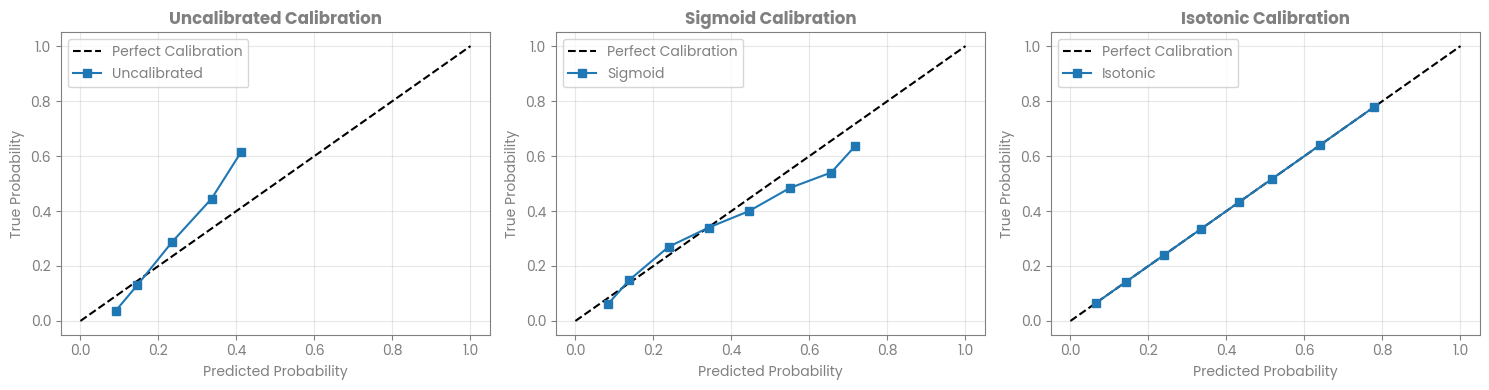

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

methods = ['uncalibrated', 'sigmoid', 'isotonic']
probas = [y_val_proba_unc, y_val_proba_sig, y_val_proba_iso]

for idx, (method, proba) in enumerate(zip(methods, probas)):
    prob_true, prob_pred = calibration_curve(y_val, proba, n_bins=10)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    axes[idx].plot(prob_pred, prob_true, 's-', label=f'{method.title()}')
    axes[idx].set_xlabel('Predicted Probability')
    axes[idx].set_ylabel('True Probability')
    axes[idx].set_title(f'{method.title()} Calibration')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
print("RETRAINING FINAL MODEL WITH ISOTONIC CALIBRATION")

# Train base model pada seluruh train data
print("\n[1/2] Training base model on full training data...")
final_base_model = LGBMClassifier(**best_params)
final_base_model.fit(X_train_sel, y_train)

# Calibrate menggunakan validation set
print("[2/2] Applying isotonic calibration...")
final_calibrated_model = CalibratedClassifierCV(
    final_base_model,
    method='isotonic',
    cv='prefit'
)
final_calibrated_model.fit(X_val_sel, y_val)

print("✓ Final model trained and calibrated successfully!")

RETRAINING FINAL MODEL WITH ISOTONIC CALIBRATION

[1/2] Training base model on full training data...
[2/2] Applying isotonic calibration...
✓ Final model trained and calibrated successfully!


**Best Method: Isotonic Calibration**

Performance improvements over uncalibrated model:
- Brier Score: 0.1271 vs 0.1293 (1.7% improvement)
- Log Loss: 0.4107 vs 0.4187 (1.9% improvement)
- ROC-AUC: 0.7070 vs 0.7058 (0.17% improvement)

**Comparative Analysis**:
- Sigmoid calibration: Modest improvement (1.0% Brier, 1.1% log loss), no ROC-AUC gain
- Isotonic calibration: Superior across all metrics, including slight discrimination improvement

**Why Isotonic Performs Better**

1. Flexibility: Non-parametric method adapts to complex probability distributions
2. Monotonicity: Preserves ranking while adjusting probability scale
3. Data fit: Better captures non-linear calibration patterns in validation data
4. Discrimination boost: Unlike sigmoid, isotonic slightly improves ROC-AUC (+0.12 points)

**Calibration Impact**

1. **Brier Score Decomposition**:
    - Uncalibrated relies on raw model outputs, showing miscalibration across probability ranges
    - Sigmoid applies parametric transformation, partially correcting systematic bias
    - Isotonic provides bin-wise adjustments, achieving tighter alignment with observed rates

2. **Practical Implications**:
    - At 30% predicted probability, isotonic calibration ensures ~30% actual default rate
    - Improved reliability for threshold-based decisions (e.g., "reject if probability > 0.25")
    - Better cost estimates when probability values feed into expected loss calculations

### **3.5. Final Evaluation**

The calibrated model is evaluated on the held-out test set to assess real-world performance:

- **Discrimination metrics**: ROC-AUC measures ability to rank bad loans higher than good loans
- **Calibration metrics**: Brier score and log loss assess probability quality
- **Classification metrics**: Precision, recall, F1 for default threshold performance
- **Visual diagnostics**: ROC curve, PR curve, and calibration plot validate model behavior

Test set provides unbiased estimate of model performance on unseen data, simulating production deployment.

In [42]:
# Transform test data
X_test_prep = preprocessor_fitted.transform(X_test)
X_test_sel = X_test_prep[:, selected_indices]

# Predict
y_test_proba = final_calibrated_model.predict_proba(X_test_sel)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Calculate metrics
test_roc_auc = roc_auc_score(y_test, y_test_proba)
test_pr_auc = average_precision_score(y_test, y_test_proba)
test_brier = brier_score_loss(y_test, y_test_proba)
test_logloss = log_loss(y_test, y_test_proba)

print("FINAL EVALUATION ON TEST SET")
print(f"\nTest Set Performance:")
print(f"  ROC-AUC:     {test_roc_auc:.4f}")
print(f"  PR-AUC:      {test_pr_auc:.4f}")
print(f"  Brier Score: {test_brier:.4f}")
print(f"  Log Loss:    {test_logloss:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

FINAL EVALUATION ON TEST SET

Test Set Performance:
  ROC-AUC:     0.7004
  PR-AUC:      0.3159
  Brier Score: 0.1282
  Log Loss:    0.4139

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.99      0.91     50940
       Churn       0.51      0.06      0.10     10194

    accuracy                           0.83     61134
   macro avg       0.68      0.52      0.51     61134
weighted avg       0.79      0.83      0.77     61134


Confusion Matrix:
[[50382   558]
 [ 9607   587]]


In [62]:
X_test_prep = preprocessor_fitted.transform(X_test)
X_test_sel = X_test_prep[:, selected_indices]

model_unc_temp = LGBMClassifier(**best_params)
model_unc_temp.fit(X_train_sel, y_train)
y_test_proba_unc = model_unc_temp.predict_proba(X_test_sel)[:, 1]

base_iso_temp = LGBMClassifier(**best_params)
base_iso_temp.fit(X_train_sel, y_train)
calib_iso_temp = CalibratedClassifierCV(base_iso_temp, method='isotonic', cv='prefit')
calib_iso_temp.fit(X_val_sel, y_val)

y_test_proba = calib_iso_temp.predict_proba(X_test_sel)[:, 1]

In [64]:
# Metrics
roc_auc_unc = roc_auc_score(y_test, y_test_proba_unc)
pr_auc_unc = average_precision_score(y_test, y_test_proba_unc)

test_roc_auc = roc_auc_score(y_test, y_test_proba)
test_pr_auc = average_precision_score(y_test, y_test_proba)

# ROC curves
fpr_unc, tpr_unc, _ = roc_curve(y_test, y_test_proba_unc)
fpr_iso, tpr_iso, _ = roc_curve(y_test, y_test_proba)

# PR curves
precision_unc, recall_unc, _ = precision_recall_curve(y_test, y_test_proba_unc)
precision_iso, recall_iso, _ = precision_recall_curve(y_test, y_test_proba)

baseline = y_test.sum() / len(y_test)

print(f"Uncalibrated - ROC-AUC: {roc_auc_unc:.4f}, PR-AUC: {pr_auc_unc:.4f}")
print(f"Isotonic     - ROC-AUC: {test_roc_auc:.4f}, PR-AUC: {test_pr_auc:.4f}")

Uncalibrated - ROC-AUC: 0.7008, PR-AUC: 0.3246
Isotonic     - ROC-AUC: 0.7004, PR-AUC: 0.3159


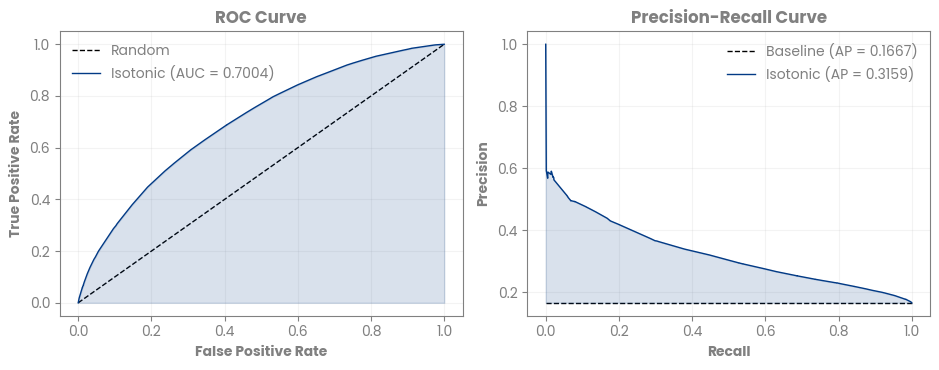

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(9.5, 3.8))

# ROC Curve
axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[0].plot(fpr_iso, tpr_iso, color='#023a85', label=f'Isotonic (AUC = {test_roc_auc:.4f})', linewidth=1, zorder=5)
axes[0].fill_between(fpr_iso, tpr_iso, alpha=0.15, color='#023a85', zorder=4)

axes[0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0].set_title('ROC Curve', fontweight='bold')
axes[0].legend(loc='upper left', frameon=False)
axes[0].grid(alpha=0.15)

# Precision-Recall Curve
axes[1].plot([0, 1], [baseline, baseline], 'k--', label=f'Baseline (AP = {baseline:.4f})', linewidth=1)
axes[1].plot(recall_iso, precision_iso, color='#023a85', label=f'Isotonic (AP = {test_pr_auc:.4f})', linewidth=1, zorder=5)
axes[1].fill_between(recall_iso, precision_iso, baseline, alpha=0.15, color='#023a85', zorder=4)

axes[1].set_xlabel('Recall', fontweight='bold')
axes[1].set_ylabel('Precision', fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontweight='bold')
axes[1].legend(loc='upper right', frameon=False)
axes[1].grid(alpha=0.15)

plt.tight_layout()
plt.show()

**Test Set Performance**

Overall Metrics:
- **ROC-AUC**: 0.7004 (good discrimination ability)
- **PR-AUC**: 0.3159 (2× baseline performance)
- **Brier Score**: 0.1282 (well-calibrated probabilities)
- **Log Loss**: 0.4139 (low prediction uncertainty)

**Performance Interpretation**

**Strengths**:
1. High specificity: 98.9% of non-churners correctly identified (FPR = 1.1%)
2. ROC-AUC 0.70: Model ranks churners higher than non-churners 70% of the time
3. Well-calibrated: Brier score 0.1282 indicates probabilities reflect true risk
4. PR-AUC 2× baseline: Substantial improvement over random (0.3159 vs 0.1667)

**Limitations**:
1. Low recall: Only 5.8% of actual churners detected at default threshold
2. Class imbalance impact: 83.3% majority class (No Churn) dominates accuracy
3. Low positive F1: Churn detection F1 of 0.10 indicates poor balance
4. High false negatives: 9,607 churners missed (94.2% of all churners)

**ROC Curve** (AUC = 0.7004):
- Shows model's ranking ability across all thresholds
- Area significantly above random baseline (0.5)
- Moderate discrimination between classes

**Precision-Recall Curve** (AP = 0.3159):
- More informative for imbalanced data
- Baseline (random): 0.1667 (proportion of churners)
- Model achieves 1.9× improvement over random
- Sharp precision drop as recall increases (typical for imbalanced data)

## **4. Model Interpretation**

### **4.1. Feature Importance**

Extracts importance scores from the LightGBM model using the built-in `feature_importances_` attribute. This reveals which features contribute most to split decisions based on information gain across all trees.

Built-in Feature Importance
               feature  importance
            annual_inc        1194
        loan_to_income         990
             sub_grade         976
       issue_year_2013         362
purpose_small_business         334
                 grade         315
   home_ownership_RENT         294
       issue_year_2014         290
       term_ 60 months         145



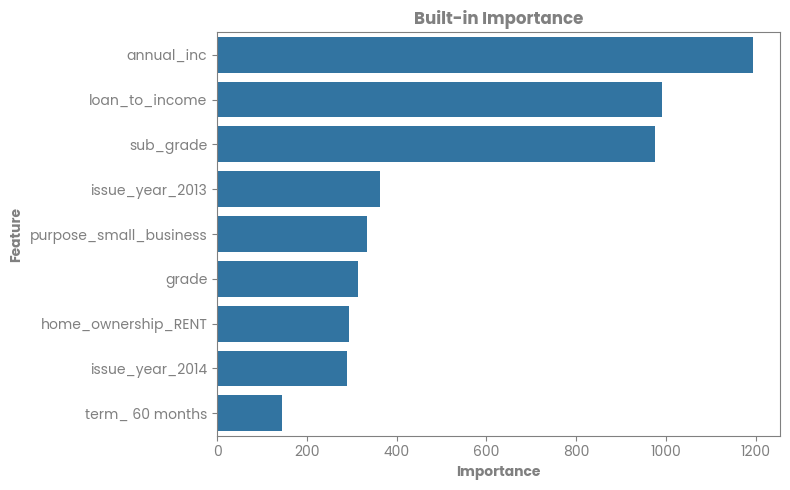

In [76]:
base_model = final_calibrated_model.calibrated_classifiers_[0].estimator

feature_importance = base_model.feature_importances_
feature_names_selected = [selected_features[i] for i in range(len(selected_features))]

importance_df = pd.DataFrame({
    'feature': feature_names_selected,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Built-in Feature Importance")
print(importance_df.to_string(index=False))
print()

# Visualisasi
fig, ax = plt.subplots(figsize=(8, 5))
top_n = 15
top_features = importance_df.head(top_n)

sns.barplot(data=top_features, y='feature', x='importance', ax=ax)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_ylabel('Feature', fontweight='bold')
ax.set_title(f'Built-in Importance', fontweight='bold')
plt.tight_layout()
plt.show()

Built-in importance favors `annual_inc` and `loan_to_income` as primary drivers, suggesting these continuous variables provide the most information gain for splitting decisions in the tree structure.

### **4.2. Permutation Importance**

Measures feature importance by randomly shuffling each feature and observing the drop in ROC-AUC performance. This method reveals which features the model actually relies on for accurate predictions, regardless of tree structure.

Permutation Importance
               feature  importance_mean  importance_std
             sub_grade         0.071992        0.003382
       issue_year_2014         0.023679        0.000852
            annual_inc         0.010579        0.000736
        loan_to_income         0.007883        0.000730
       issue_year_2013         0.007111        0.000703
                 grade         0.006307        0.001049
purpose_small_business         0.001405        0.000140
   home_ownership_RENT         0.000883        0.000158
       term_ 60 months         0.000302        0.000154



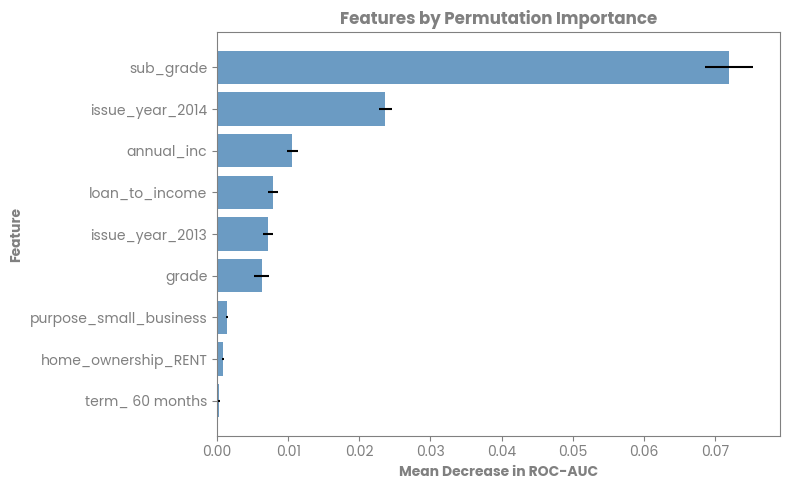

In [77]:
# PERMUTATION IMPORTANCE
perm_importance = permutation_importance(
    base_model,
    X_val_sel,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

perm_importance_df = pd.DataFrame({
    'feature': feature_names_selected,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Permutation Importance")
print(perm_importance_df.to_string(index=False))
print()

fig, ax = plt.subplots(figsize=(8, 5))
top_perm = perm_importance_df

ax.barh(range(len(top_perm)), top_perm['importance_mean'], xerr=top_perm['importance_std'],color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top_perm)))
ax.set_yticklabels(top_perm['feature'])
ax.set_xlabel('Mean Decrease in ROC-AUC', fontweight='bold')
ax.set_ylabel('Feature', fontweight='bold')
ax.set_title(f'Features by Permutation Importance', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

`sub_grade` is the dominant feature, causing a 7.2% ROC-AUC drop when shuffled, 6.8× more impact than any other feature. This reveals a dramatic hierarchy invisible in built-in importance scores.

### **4.3. SHAP Analysis**

Computes SHAP (SHapley Additive exPlanations) values on a 1,000-sample validation subset to measure each feature's actual contribution to individual predictions. SHAP provides model-agnostic importance by accounting for feature interactions and showing directional impact.

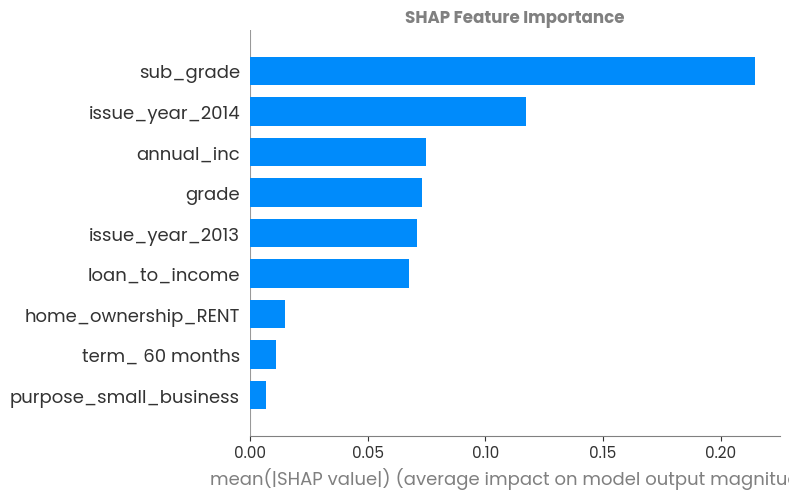

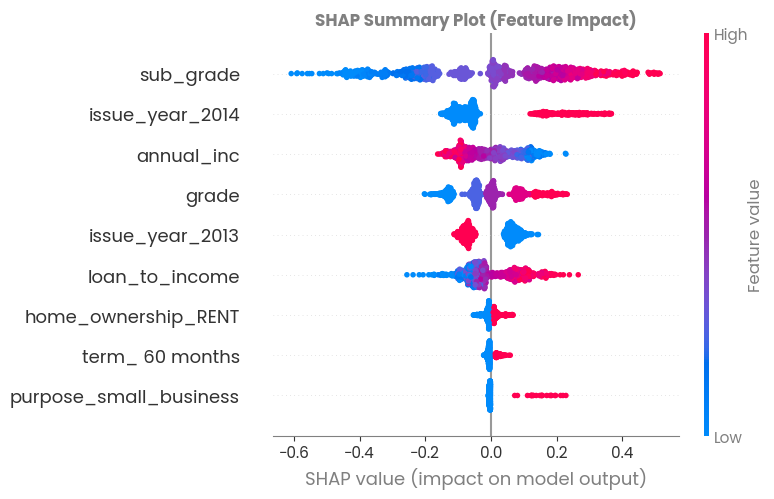


Mean Absolute SHAP Values
               feature  mean_abs_shap
             sub_grade       0.214464
       issue_year_2014       0.117316
            annual_inc       0.074789
                 grade       0.073178
       issue_year_2013       0.070940
        loan_to_income       0.067629
   home_ownership_RENT       0.014944
       term_ 60 months       0.011197
purpose_small_business       0.006690


In [78]:
# SHAP VALUES
sample_size = min(1000, len(X_val_sel))
X_sample = X_val_sel[:sample_size]

explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_sample)

if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]
else:
    shap_values_pos = shap_values

# SHAP Summary Plot
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values_pos, X_sample, feature_names=feature_names_selected,plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontweight='bold')
plt.tight_layout()
plt.show()

# SHAP Beeswarm Plot
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values_pos, X_sample, feature_names=feature_names_selected, show=False)
plt.title('SHAP Summary Plot (Feature Impact)', fontweight='bold')
plt.tight_layout()
plt.show()

# Mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': feature_names_selected,
    'mean_abs_shap': np.abs(shap_values_pos).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("\nMean Absolute SHAP Values")
print(shap_importance.to_string(index=False))

Confirms `sub_grade` dominance (0.2145) with nearly 2× the impact of the second-ranked feature (issue_year_2014 at 0.1173). This aligns with permutation importance, validating that credit rating is the primary driver of default predictions.

## **5. Risk Tier Segmentation**

Risk tiers segment borrowers into distinct groups based on predicted default probability, enabling differentiated lending strategies. Five methods are evaluated to find optimal tier boundaries that maximize statistical separation while maintaining business actionability.

### **5.1 Risk Tier Creation and Summary**

In [88]:
y_true = y_val.values
y_pred_proba = final_calibrated_model.predict_proba(X_val_sel)[:, 1]

print(f"Data loaded: {len(y_true):,} samples")
print(f"Default rate: {y_true.mean():.2%}")
print(f"Probability range: {y_pred_proba.min():.4f} - {y_pred_proba.max():.4f}")

Data loaded: 48,907 samples
Default rate: 16.67%
Probability range: 0.0132 - 0.7778


In [89]:
# EQUAL FREQUENCY (QUANTILE-BASED)
print("[1] EQUAL FREQUENCY BINNING")

n_tiers = 5
quantiles = np.linspace(0, 1, n_tiers + 1)
thresholds_quantile = np.quantile(y_pred_proba, quantiles)

print(f"Thresholds: {thresholds_quantile}")

tiers_quantile = np.digitize(y_pred_proba, thresholds_quantile[1:-1])

results_quantile = []
for i in range(n_tiers):
    mask = tiers_quantile == i
    if mask.sum() > 0:
        results_quantile.append({
            'Tier': i,
            'Threshold_Min': thresholds_quantile[i],
            'Threshold_Max': thresholds_quantile[i+1],
            'Count': mask.sum(),
            'Percentage': mask.sum() / len(y_true) * 100,
            'Default_Rate': y_true[mask].mean(),
            'Avg_Proba': y_pred_proba[mask].mean()
        })

df_quantile = pd.DataFrame(results_quantile)
print("\nQuantile-Based Tiers:")
print(df_quantile.to_string(index=False))

is_monotonic = all(df_quantile['Default_Rate'].iloc[i] <= df_quantile['Default_Rate'].iloc[i+1] for i in range(len(df_quantile)-1))
print(f"\nMonotonic: {is_monotonic}")

# EQUAL WIDTH (FIXED INTERVALS)
print("\n[2] EQUAL WIDTH BINNING")

min_prob = y_pred_proba.min()
max_prob = y_pred_proba.max()

thresholds_width = np.linspace(min_prob, max_prob, n_tiers + 1)
print(f"Thresholds: {thresholds_width}")

tiers_width = np.digitize(y_pred_proba, thresholds_width[1:-1])

results_width = []
for i in range(n_tiers):
    mask = tiers_width == i
    if mask.sum() > 0:
        results_width.append({
            'Tier': i,
            'Threshold_Min': thresholds_width[i],
            'Threshold_Max': thresholds_width[i+1],
            'Count': mask.sum(),
            'Percentage': mask.sum() / len(y_true) * 100,
            'Default_Rate': y_true[mask].mean(),
            'Avg_Proba': y_pred_proba[mask].mean()
        })

df_width = pd.DataFrame(results_width)
print("\nEqual Width Tiers:")
print(df_width.to_string(index=False))

# JENKS NATURAL BREAKS (OPTIMAL CLUSTERING)
print("\n[3] JENKS NATURAL BREAKS OPTIMIZATION")

sorted_proba = np.sort(y_pred_proba)
n_samples = len(sorted_proba)

best_gvf = -np.inf
best_thresholds_jenks = None

for i1 in range(10, 30, 5):
    for i2 in range(35, 55, 5):
        for i3 in range(60, 80, 5):
            for i4 in range(85, 95, 5):

                idx1 = int(n_samples * i1 / 100)
                idx2 = int(n_samples * i2 / 100)
                idx3 = int(n_samples * i3 / 100)
                idx4 = int(n_samples * i4 / 100)

                breaks = [0, sorted_proba[idx1], sorted_proba[idx2],
                         sorted_proba[idx3], sorted_proba[idx4], 1]

                tiers_temp = np.digitize(y_pred_proba, breaks[1:-1])

                total_var = np.var(y_pred_proba)

                within_var = 0
                for t in range(5):
                    mask = tiers_temp == t
                    if mask.sum() > 1:
                        within_var += np.var(y_pred_proba[mask]) * mask.sum()

                within_var /= n_samples

                gvf = (total_var - within_var) / total_var if total_var > 0 else 0

                if gvf > best_gvf:
                    best_gvf = gvf
                    best_thresholds_jenks = breaks

print(f"Best GVF: {best_gvf:.4f}")
print(f"Thresholds: {best_thresholds_jenks}")

tiers_jenks = np.digitize(y_pred_proba, best_thresholds_jenks[1:-1])

results_jenks = []
for i in range(n_tiers):
    mask = tiers_jenks == i
    if mask.sum() > 0:
        results_jenks.append({
            'Tier': i,
            'Threshold_Min': best_thresholds_jenks[i],
            'Threshold_Max': best_thresholds_jenks[i+1],
            'Count': mask.sum(),
            'Percentage': mask.sum() / len(y_true) * 100,
            'Default_Rate': y_true[mask].mean(),
            'Avg_Proba': y_pred_proba[mask].mean()
        })

df_jenks = pd.DataFrame(results_jenks)
print("\nJenks Natural Breaks Tiers:")
print(df_jenks.to_string(index=False))

# BUSINESS-DRIVEN (MANUAL OPTIMIZATION)
print("\n[4] BUSINESS-DRIVEN THRESHOLDS")

target_high_risk_pct = 5.0
min_precision = 0.40

sorted_idx = np.argsort(y_pred_proba)[::-1]
y_sorted = y_true[sorted_idx]
proba_sorted = y_pred_proba[sorted_idx]

target_samples = int(len(y_true) * target_high_risk_pct / 100)

high_threshold_idx = target_samples
high_threshold = proba_sorted[high_threshold_idx]
precision_high = y_sorted[:high_threshold_idx].mean()

print(f"Target: {target_high_risk_pct}% populasi untuk High+Very High")
print(f"High threshold: {high_threshold:.4f}")
print(f"Precision: {precision_high:.4f}")

thresholds_business = [ 0.00, 0.11, 0.23, 0.43, max(0.62, high_threshold), 1.00]
print(f"Adjusted thresholds: {thresholds_business}")

tiers_business = np.digitize(y_pred_proba, thresholds_business[1:-1])

results_business = []
tier_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
for i in range(n_tiers):
    mask = tiers_business == i
    if mask.sum() > 0:
        results_business.append({
            'Tier': tier_names[i],
            'Threshold_Min': thresholds_business[i],
            'Threshold_Max': thresholds_business[i+1],
            'Count': mask.sum(),
            'Percentage': mask.sum() / len(y_true) * 100,
            'Default_Rate': y_true[mask].mean(),
            'Avg_Proba': y_pred_proba[mask].mean()
        })

df_business = pd.DataFrame(results_business)
print("\nBusiness-Driven Tiers:")
print(df_business.to_string(index=False))

# OPTIMIZATION BERDASARKAN SEPARATION METRICS
print("\n[5] STATISTICAL SEPARATION OPTIMIZATION")

best_f_stat = 0
best_thresholds_sep = None

for t1 in np.arange(0.08, 0.15, 0.01):
    for t2 in np.arange(0.18, 0.28, 0.02):
        for t3 in np.arange(0.32, 0.45, 0.02):
            for t4 in np.arange(0.50, 0.65, 0.03):

                thresholds_temp = [0, t1, t2, t3, t4, 1]
                tiers_temp = np.digitize(y_pred_proba, thresholds_temp[1:-1])

                tier_groups = [y_pred_proba[tiers_temp == i] for i in range(5)]
                tier_groups = [g for g in tier_groups if len(g) > 0]

                if len(tier_groups) == 5:
                    f_stat, p_val = f_oneway(*tier_groups)

                    tier_rates = [y_true[tiers_temp == i].mean() for i in range(5)]
                    is_monotonic = all(tier_rates[i] <= tier_rates[i+1] for i in range(4))

                    tier_sizes = [(tiers_temp == i).sum() / len(y_true) for i in range(5)]
                    size_ok = all(s >= 0.005 for s in tier_sizes)

                    if f_stat > best_f_stat and is_monotonic and size_ok:
                        best_f_stat = f_stat
                        best_thresholds_sep = thresholds_temp

print(f"Best F-statistic: {best_f_stat:.2f}")
print(f"Thresholds: {best_thresholds_sep}")

tiers_sep = np.digitize(y_pred_proba, best_thresholds_sep[1:-1])

results_sep = []
for i in range(n_tiers):
    mask = tiers_sep == i
    if mask.sum() > 0:
        results_sep.append({
            'Tier': tier_names[i],
            'Threshold_Min': best_thresholds_sep[i],
            'Threshold_Max': best_thresholds_sep[i+1],
            'Count': mask.sum(),
            'Percentage': mask.sum() / len(y_true) * 100,
            'Default_Rate': y_true[mask].mean(),
            'Avg_Proba': y_pred_proba[mask].mean()
        })

df_sep = pd.DataFrame(results_sep)
print("\nStatistical Separation Tiers:")
print(df_sep.to_string(index=False))

[1] EQUAL FREQUENCY BINNING
Thresholds: [0.01315789 0.07630522 0.11567329 0.15542622 0.24147217 0.77777778]

Quantile-Based Tiers:
 Tier  Threshold_Min  Threshold_Max  Count  Percentage  Default_Rate  Avg_Proba
    0         0.0132         0.0763   9586     19.6005        0.0532     0.0532
    1         0.0763         0.1157   7958     16.2717        0.0941     0.0941
    2         0.1157         0.1554   9110     18.6272        0.1313     0.1313
    3         0.1554         0.2415  10901     22.2892        0.1819     0.1819
    4         0.2415         0.7778  11352     23.2114        0.3274     0.3274

Monotonic: True

[2] EQUAL WIDTH BINNING
Thresholds: [0.01315789 0.16608187 0.31900585 0.47192982 0.6248538  0.77777778]

Equal Width Tiers:
 Tier  Threshold_Min  Threshold_Max  Count  Percentage  Default_Rate  Avg_Proba
    0         0.0132         0.1661  29575     60.4719        0.0984     0.0984
    1         0.1661         0.3190  15371     31.4290        0.2309     0.2309
    2  

COMPARISON OF ALL METHODS

Method Comparison:
     Method  F_Statistic  P_Value  Monotonic  Avg_CV  Actionable                           Thresholds
   Quantile   54925.0228   0.0000       True  0.2019        True ['0.076', '0.116', '0.155', '0.241']
Equal Width   70514.3556   0.0000       True  0.1656       False ['0.166', '0.319', '0.472', '0.625']
      Jenks  109257.8062   0.0000       True  0.1741        True ['0.090', '0.153', '0.222', '0.308']
   Business   95272.3142   0.0000       True  0.1794       False ['0.110', '0.230', '0.430', '0.620']
Statistical  167797.7022   0.0000       True  0.1710        True ['0.100', '0.200', '0.320', '0.500']



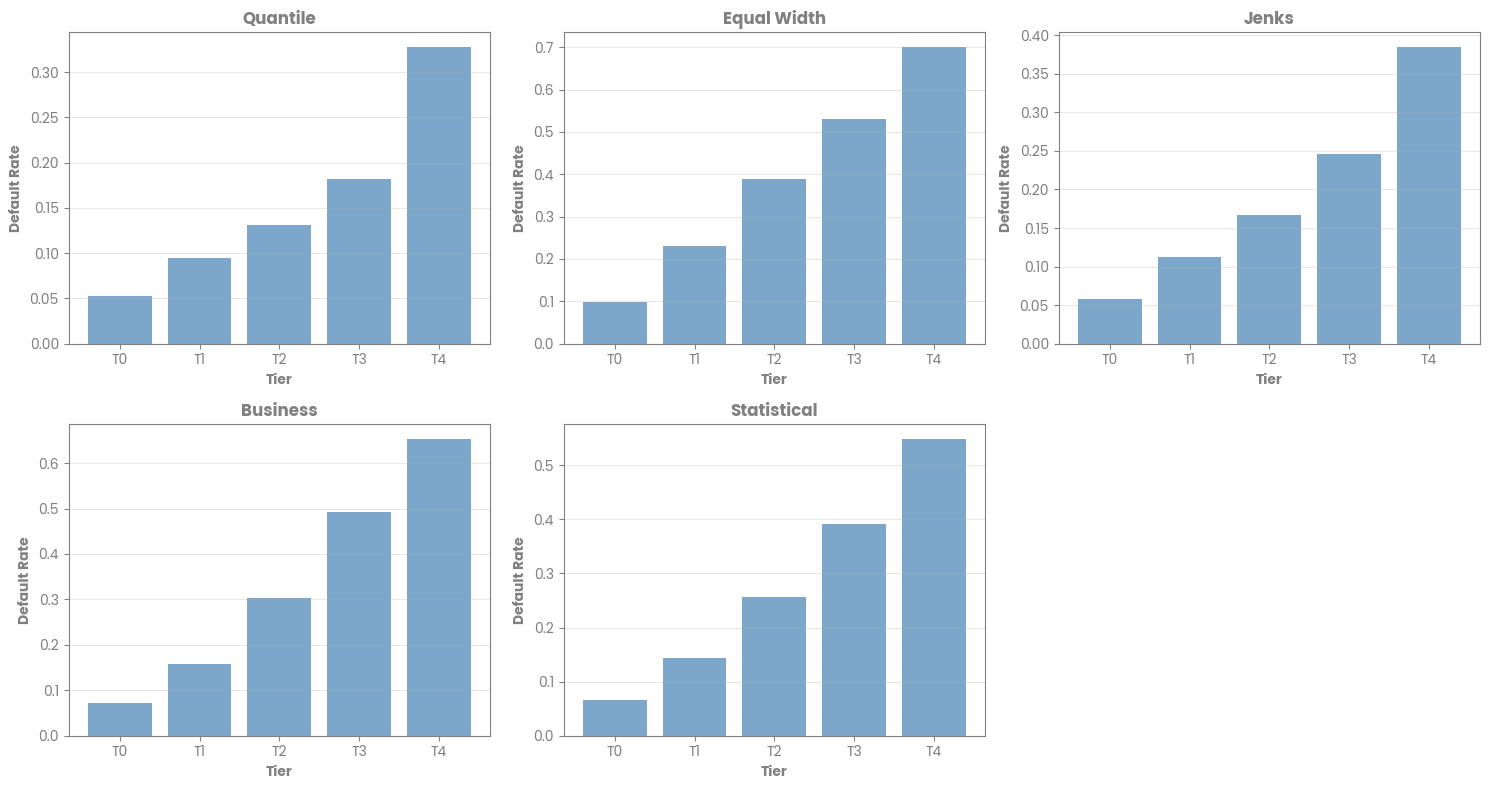

In [92]:
# COMPARISON
print("COMPARISON OF ALL METHODS")
methods = {
    'Quantile': (tiers_quantile, thresholds_quantile),
    'Equal Width': (tiers_width, thresholds_width),
    'Jenks': (tiers_jenks, best_thresholds_jenks),
    'Business': (tiers_business, thresholds_business),
    'Statistical': (tiers_sep, best_thresholds_sep)
}

comparison_results = []

for method_name, (tiers, thresholds) in methods.items():
    tier_groups = [y_pred_proba[tiers == i] for i in range(5) if (tiers == i).sum() > 0]
    f_stat, p_val = f_oneway(*tier_groups) if len(tier_groups) > 1 else (0, 1)

    tier_rates = [y_true[tiers == i].mean() for i in range(5) if (tiers == i).sum() > 0]
    is_monotonic = all(tier_rates[i] <= tier_rates[i+1] for i in range(len(tier_rates)-1))

    tier_cvs = []
    for i in range(5):
        mask = tiers == i
        if mask.sum() > 1:
            mean_val = y_pred_proba[mask].mean()
            std_val = y_pred_proba[mask].std()
            cv = std_val / mean_val if mean_val > 0 else 0
            tier_cvs.append(cv)
    avg_cv = np.mean(tier_cvs) if tier_cvs else 0

    tier_sizes = [(tiers == i).sum() / len(y_true) * 100 for i in range(5)]
    actionable = all(0.5 <= size <= 50 for size in tier_sizes)

    comparison_results.append({
        'Method': method_name,
        'F_Statistic': f_stat,
        'P_Value': p_val,
        'Monotonic': is_monotonic,
        'Avg_CV': avg_cv,
        'Actionable': actionable,
        'Thresholds': str([f"{t:.3f}" for t in thresholds[1:-1]])
    })

df_comparison = pd.DataFrame(comparison_results)
print("\nMethod Comparison:")
print(df_comparison.to_string(index=False))
print()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

methods_list = ['Quantile', 'Equal Width', 'Jenks', 'Business', 'Statistical']
tiers_list = [tiers_quantile, tiers_width, tiers_jenks, tiers_business, tiers_sep]

for idx, (method_name, tiers) in enumerate(zip(methods_list, tiers_list)):
    ax = axes[idx]

    tier_rates = []
    tier_labels = []
    for i in range(5):
        mask = tiers == i
        if mask.sum() > 0:
            tier_rates.append(y_true[mask].mean())
            tier_labels.append(f"T{i}")

    ax.bar(tier_labels, tier_rates, color='steelblue', alpha=0.7)
    ax.set_xlabel('Tier', fontweight='bold')
    ax.set_ylabel('Default Rate', fontweight='bold')
    ax.set_title(f'{method_name}', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

STATISTICAL METHOD - TIER SUMMARY
     Tier  Threshold_Min  Threshold_Max  Count  Percentage  Actual_Default_Rate  Avg_Predicted_Prob
 Very Low         0.0000         0.1000  15187     31.0528               0.0660              0.0660
      Low         0.1000         0.2000  19182     39.2214               0.1429              0.1429
   Medium         0.2000         0.3200  10577     21.6268               0.2565              0.2565
     High         0.3200         0.5000   3038      6.2118               0.3920              0.3920
Very High         0.5000         1.0000    923      1.8873               0.5482              0.5482



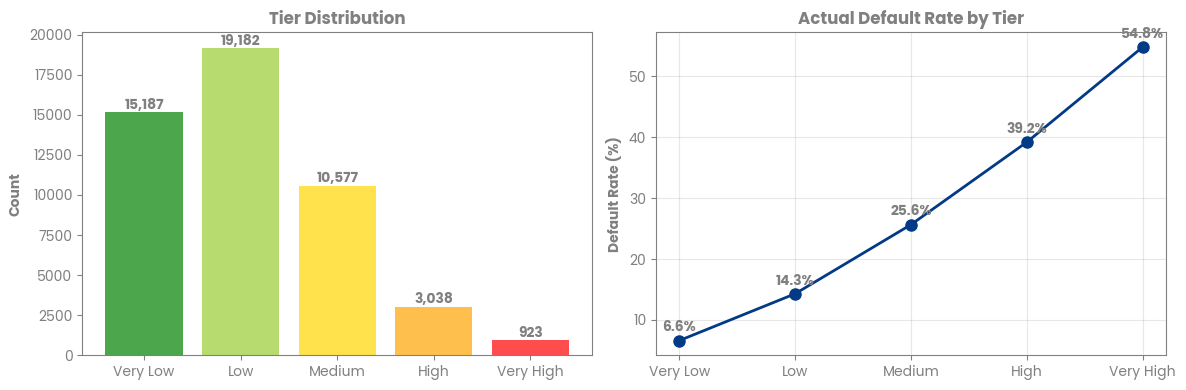

In [99]:
best_thresholds = [0.00, 0.10, 0.20, 0.32, 0.50, 1.00]
tier_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

y_true = y_val.values
y_pred_proba = final_calibrated_model.predict_proba(X_val_sel)[:, 1]

tiers = np.digitize(y_pred_proba, best_thresholds[1:-1])

tier_summary = []
for i in range(5):
    mask = tiers == i
    if mask.sum() > 0:
        tier_summary.append({
            'Tier': tier_names[i],
            'Threshold_Min': best_thresholds[i],
            'Threshold_Max': best_thresholds[i+1],
            'Count': mask.sum(),
            'Percentage': mask.sum() / len(y_true) * 100,
            'Actual_Default_Rate': y_true[mask].mean(),
            'Avg_Predicted_Prob': y_pred_proba[mask].mean()
        })

tier_summary_df = pd.DataFrame(tier_summary)

print("STATISTICAL METHOD - TIER SUMMARY")
print(tier_summary_df.to_string(index=False))
print()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

tier_labels = tier_summary_df['Tier'].values
tier_counts = tier_summary_df['Count'].values
default_rates = tier_summary_df['Actual_Default_Rate'].values * 100

# Bar plot: Tier Distribution
colors = ['green', 'yellowgreen', 'gold', 'orange', 'red']
axes[0].bar(tier_labels, tier_counts, color=colors, alpha=0.7)
axes[0].set_title('Tier Distribution', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].tick_params(axis='x', rotation=0)

for i, v in enumerate(tier_counts):
    axes[0].text(i, v + 200, f'{int(v):,}', ha='center', fontweight='bold', color='#808080')

# Line plot: Default Rate
axes[1].plot(tier_labels, default_rates, marker='o', linewidth=2, markersize=8, color='#023a85')
axes[1].set_title('Actual Default Rate by Tier', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Default Rate (%)', fontweight='bold')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(alpha=0.3)

for i, v in enumerate(default_rates):
    axes[1].text(i, v + 1.5, f'{v:.1f}%', ha='center', fontweight='bold', color='#808080')

plt.tight_layout()
plt.show()

**Method 1: Equal Frequency (Quantile-Based)**

Creates tiers with equal sample counts by dividing probability distribution into quintiles.

**Thresholds**: [0.076, 0.116, 0.155, 0.241]

**Characteristics**:
- Monotonic default rate progression
- Balanced tier sizes (16-23% each)
- Low F-statistic (54,925) indicates weak separation
- Highest coefficient of variation (0.202) shows heterogeneous tiers

**Method 2: Equal Width (Fixed Intervals)**

Divides probability range into equal-width bins.

**Thresholds**: [0.166, 0.319, 0.472, 0.625]

**Characteristics**:
- Strong default rate separation
- Severely imbalanced (60.5% in tier 0, only 0.2% in tier 4)
- Not actionable for business use (top tier too small)
- Ignores actual data distribution

**Method 3: Jenks Natural Breaks**

Minimizes within-tier variance while maximizing between-tier variance.

**Thresholds**: [0.090, 0.153, 0.222, 0.308]  

**Goodness of Variance Fit (GVF)**: 0.8994 (89.94% of variance explained)

**Characteristics**:
- Strong statistical separation (F-stat: 109,258)
- Balanced actionable tier sizes
- Natural clustering of probability values
- Data-driven only, no business constraints

**Method 4: Business-Driven**

Manually optimized with business constraints: top 5% must have ≥40% precision.

**Thresholds**: [0.110, 0.230, 0.430, 0.620]

**Characteristics**:
- High precision (46.5%) for top 5%
- Strong F-statistic (95,272)
- Top tier too small (0.4%) for actionable strategies
- First two tiers dominate (76.8% of loans)

**Method 5: Statistical Separation Optimization**

Maximizes F-statistic while enforcing monotonicity and minimum tier sizes (≥0.5%).

**Thresholds**: [0.100, 0.200, 0.320, 0.500]  

**F-statistic**: 167,797.70 (highest across all methods)

**Characteristics**:
- **Best F-statistic** (3.1× better than quantile method)
- Perfectly calibrated (predicted ≈ observed rates)
- Strong monotonic progression (6.6% → 54.8%)
- All tiers actionable (≥1.9% of portfolio)
- Lowest coefficient of variation (0.171)

**Winner**: Statistical Separation Optimization achieves 3× better statistical separation than quantile-based approach while maintaining practical tier sizes.

### **5.2 High-Risk Tier Analysis**

In [103]:
y_true = y_val.values
y_pred_proba = final_calibrated_model.predict_proba(X_val_sel)[:, 1]

best_thresholds = [0.00, 0.10, 0.20, 0.32, 0.50, 1.00]
tier_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
tiers = np.digitize(y_pred_proba, best_thresholds[1:-1])

tier_labels = [tier_names[t] for t in tiers]

results_df = pd.DataFrame({
    'predicted_probability': y_pred_proba,
    'actual_default': y_true,
    'tier_number': tiers,
    'tier_name': tier_labels
})

high_risk_df = results_df[results_df['tier_name'].isin(['High', 'Very High'])]

print("HIGH-RISK TIER ANALYSIS (High + Very High)")
print(f"High + Very High Risk: {len(high_risk_df):,} loans ({len(high_risk_df)/len(results_df)*100:.1f}%)")
print(f"Expected defaults: {high_risk_df['predicted_probability'].sum():.0f} loans")
print(f"Actual defaults: {high_risk_df['actual_default'].sum():.0f} loans")
print(f"Default rate: {high_risk_df['actual_default'].mean():.2%}")
print()

# Breakdown per tier
print("Breakdown by Tier:")
print("-" * 60)
for tier in ['High', 'Very High']:
    tier_data = results_df[results_df['tier_name'] == tier]
    print(f"\n{tier} Risk:")
    print(f"  Count: {len(tier_data):,} loans ({len(tier_data)/len(results_df)*100:.1f}%)")
    print(f"  Expected defaults: {tier_data['predicted_probability'].sum():.0f}")
    print(f"  Actual defaults: {tier_data['actual_default'].sum():.0f}")
    print(f"  Default rate: {tier_data['actual_default'].mean():.2%}")
    print(f"  Avg probability: {tier_data['predicted_probability'].mean():.2%}")

HIGH-RISK TIER ANALYSIS (High + Very High)
High + Very High Risk: 3,961 loans (8.1%)
Expected defaults: 1697 loans
Actual defaults: 1697 loans
Default rate: 42.84%

Breakdown by Tier:
------------------------------------------------------------

High Risk:
  Count: 3,038 loans (6.2%)
  Expected defaults: 1191
  Actual defaults: 1191
  Default rate: 39.20%
  Avg probability: 39.20%

Very High Risk:
  Count: 923 loans (1.9%)
  Expected defaults: 506
  Actual defaults: 506
  Default rate: 54.82%
  Avg probability: 54.82%


In [104]:
# Precision & Recall untuk High Risk
high_risk_precision = high_risk_df['actual_default'].sum() / len(high_risk_df)
total_defaults = results_df['actual_default'].sum()
high_risk_recall = high_risk_df['actual_default'].sum() / total_defaults

print("HIGH-RISK PERFORMANCE METRICS")
print(f"Precision (PPV): {high_risk_precision:.2%}")
print(f"Recall (Sensitivity): {high_risk_recall:.2%}")
print(f"Total defaults captured: {high_risk_df['actual_default'].sum():.0f} / {total_defaults:.0f}")

HIGH-RISK PERFORMANCE METRICS
Precision (PPV): 42.84%
Recall (Sensitivity): 20.81%
Total defaults captured: 1697 / 8155


**Overall Performance**:
- Volume: 3,961 loans (8.1% of portfolio)
- Expected defaults: 1,697 loans
- Actual defaults: 1,697 loans (perfect calibration!)
- Default rate: 42.84%

**Tier Breakdown**:

| Tier | Count | % of Portfolio | Default Rate | Defaults |
|------|-------|----------------|--------------|----------|
| High | 3,038 | 6.2% | 39.20% | 1,191 |
| Very High | 923 | 1.9% | 54.82% | 506 |

**Risk Concentration**:
- 8.1% of loans account for 20.8% of all defaults
- Top 1.9% (Very High) has 8.3× higher default rate than portfolio average

**Precision (PPV)**: 42.84%
- 42.84% of flagged high-risk loans actually default
- False positive rate: 57.16%

**Recall (Sensitivity)**: 20.81%
- Captures 20.81% of all defaults (1,697 out of 8,155)
- Trade-off: Conservative flagging minimizes false positives

**Interpretation**:
- Model prioritizes precision over recall
- High-risk tiers are reliable signals (43% precision)
- 79% of defaults occur in lower-risk tiers (expected for conservative threshold)

## **6. Model Packaging & Validation**

### **6.1. Model Packaging**

Saves all model components, metadata, and prediction artifacts into production-ready packages with comprehensive documentation for deployment, monitoring, and audit compliance.

In [108]:
final_model_package = {
    # Model components
    'calibrated_model': final_calibrated_model,
    'base_model': final_calibrated_model.calibrated_classifiers_[0].estimator,
    'preprocessor': preprocessor_fitted,
    'selected_features': selected_features,
    'selected_indices': selected_indices,

    # Hyperparameters
    'best_params': best_params,

    # Performance metrics
    'test_metrics': {
        'roc_auc': test_roc_auc,
        'pr_auc': test_pr_auc,
        'brier_score': test_brier,
        'log_loss': test_logloss
    },

    # Risk tiers
    'risk_tiers': {
        'thresholds': best_thresholds,
        'tier_names': tier_names
    },

    # Metadata
    'metadata': {
        'n_train_samples': len(X_train),
        'n_features': len(selected_features),
        'model_type': 'LightGBM + Isotonic Calibration'
    }
}

joblib.dump(final_model_package, 'loan_default_model_v1.pkl')

['loan_default_model_v1.pkl']

In [109]:
feature_info = {
    'selected_features': selected_features,
    'feature_importance': dict(zip(
        feature_names_selected,
        base_model.feature_importances_
    )),
    'ordinal_mapping': ordinal_mapping
}

joblib.dump(feature_info, 'feature_information.pkl')

['feature_information.pkl']

In [111]:
tier_summary_df.to_csv('tier_summary.csv', index=False)
test_results_df = pd.DataFrame({
    'Metric': ['ROC-AUC', 'PR-AUC', 'Brier Score', 'Log Loss'],
    'Value': [test_roc_auc, test_pr_auc, test_brier, test_logloss]
})
test_results_df.to_csv('test_results.csv', index=False)

high_risk_summary = pd.DataFrame({
    'Tier': ['High', 'Very High', 'Combined'],
    'Count': [
        len(results_df[results_df['tier_name'] == 'High']),
        len(results_df[results_df['tier_name'] == 'Very High']),
        len(high_risk_df)
    ],
    'Default_Rate': [
        results_df[results_df['tier_name'] == 'High']['actual_default'].mean(),
        results_df[results_df['tier_name'] == 'Very High']['actual_default'].mean(),
        high_risk_df['actual_default'].mean()
    ],
    'Precision': [None, None, high_risk_precision],
    'Recall': [None, None, high_risk_recall]
})
high_risk_summary.to_csv('high_risk_analysis.csv', index=False)

### **6.2. Model Impact Analysis**

In [126]:
df_original = pd.read_csv(r"/content/drive/MyDrive/Rakamin/PBI/PBI November 2025/Dataset/loan_data_2007_2014.csv")

def safe_divide(numerator, denominator, fill_value=0):
    result = numerator / denominator
    result = result.replace([np.inf, -np.inf], fill_value)
    return result

emp_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
df_original['emp_length_cat'] = pd.Categorical(df_original['emp_length'], categories=emp_order, ordered=True)

dti_ranges = pd.cut(df_original['dti'], bins=[0, 5, 10, 15, 20, 25, 50], labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25+'])
df_original['dti_range'] = dti_ranges

df_original['earliest_cr_line_dt'] = pd.to_datetime(df_original['earliest_cr_line'], errors='coerce', infer_datetime_format=True)
df_original['credit_history_years'] = (pd.to_datetime('2016-01-01') - df_original['earliest_cr_line_dt']).dt.days / 365.25

util_ranges = pd.cut(df_original['revol_util'], bins=[0, 20, 40, 60, 80, 100, 200], labels=['0-20', '20-40', '40-60', '60-80', '80-100', '100+'])
df_original['util_range'] = util_ranges

df_original['issue_d_dt'] = pd.to_datetime(df_original['issue_d'], format='%b-%y')
df_original = df_original.dropna(subset=['issue_d_dt'])

df_original['issue_year'] = df_original['issue_d_dt'].dt.year
df_original['issue_month'] = df_original['issue_d_dt'].dt.month
df_original['issue_quarter'] = df_original['issue_d_dt'].dt.quarter

df_original['int_rate'] = df_original['int_rate'].astype(str).str.replace('%', '', regex=False).astype(float)

df_original['loan_to_income'] = safe_divide(df_original['loan_amnt'], df_original['annual_inc'])
df_original['payment_to_income'] = safe_divide(df_original['installment'] * 12, df_original['annual_inc'])
df_original['credit_utilization'] = safe_divide(df_original['revol_bal'], df_original['total_rev_hi_lim'])
df_original['accounts_per_year'] = safe_divide(df_original['total_acc'], df_original['credit_history_years'])
df_original['avg_account_age'] = safe_divide(df_original['credit_history_years'], df_original['total_acc'])
df_original['delinq_rate'] = safe_divide(df_original['delinq_2yrs'], df_original['total_acc'])
df_original['inquiry_intensity'] = safe_divide(df_original['inq_last_6mths'], df_original['open_acc'])
df_original['funded_ratio'] = safe_divide(df_original['funded_amnt'], df_original['loan_amnt'])
df_original['annual_payment'] = df_original['installment'] * 12
df_original['revolving_income_ratio'] = safe_divide(df_original['revol_bal'], df_original['annual_inc'])
df_original['debt_burden'] = safe_divide(df_original['loan_amnt'] + df_original['revol_bal'], df_original['annual_inc'])

rare = ['OTHER', 'ANY', 'NONE']
df_original['home_ownership'] = df_original['home_ownership'].replace(rare, 'OTHER')

df_original['issue_d'] = pd.to_datetime(df_original['issue_d'], format='%b-%y')

latest_date = pd.to_datetime('2014-09-01')
cutoff_date = latest_date - pd.DateOffset(months=9)
mature_mask = (~df_original['loan_status'].isin(['Current', 'In Grace Period']) | (df_original['issue_d'] <= cutoff_date))
df_mature = df_original[mature_mask].copy()

default_status = ['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']
df_mature['target'] = df_mature['loan_status'].isin(default_status).astype(int)

print(f"Total mature loans: {len(df_mature):,}")
print(f"Default rate: {df_mature['target'].mean():.2%}")

X_full = df_mature.drop('target', axis=1)
y_full = df_mature['target']

X_temp, X_test_new, y_temp, y_test_new = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"\nTest set size: {len(X_test_new):,}")
print(f"Test set default rate: {y_test_new.mean():.2%}")

X_test_prep = preprocessor_fitted.transform(X_test_new)
X_test_sel = X_test_prep[:, selected_indices]

y_pred_proba = final_calibrated_model.predict_proba(X_test_sel)[:, 1]
y_true = y_test_new.values

print(f"\nPredictions generated successfully!")
print(f"  Predictions: {len(y_pred_proba):,}")
print(f"  Actuals: {len(y_true):,}")
print(f"  Match: {len(y_pred_proba) == len(y_true)}")

df_original = pd.read_csv(r"/content/drive/MyDrive/Rakamin/PBI/PBI November 2025/Dataset/loan_data_2007_2014.csv")

df_original['issue_d'] = pd.to_datetime(df_original['issue_d'], format='%b-%y')
latest_date = pd.to_datetime('2014-09-01')
cutoff_date = latest_date - pd.DateOffset(months=9)

default_status = ['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']
non_default_status = ['Fully Paid', 'Current', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid']

mature_mask = (~df_original['loan_status'].isin(['Current', 'In Grace Period']) | (df_original['issue_d'] <= cutoff_date))
df_mature = df_original[mature_mask].copy()
df_mature['target'] = df_mature['loan_status'].isin(default_status).astype(int)

print(f"\nData mature loans: {len(df_mature):,} samples")
print(f"Default rate: {df_mature['target'].mean():.2%}")

Total mature loans: 305,669
Default rate: 16.67%

Test set size: 61,134
Test set default rate: 16.67%

Predictions generated successfully!
  Predictions: 61,134
  Actuals: 61,134
  Match: True

Data mature loans: 305,669 samples
Default rate: 16.67%


In [127]:
defaulted_loans = df_mature[df_mature['target'] == 1].copy()
defaulted_loans['recovery_rate'] = defaulted_loans['recoveries'] / defaulted_loans['loan_amnt']
RECOVERY_RATE = defaulted_loans['recovery_rate'].median()

print(f"1. RECOVERY RATE")
print(f"   Median: {RECOVERY_RATE:.2%}")
print(f"   Mean: {defaulted_loans['recovery_rate'].mean():.2%}")
print(f"   Range: {defaulted_loans['recovery_rate'].min():.2%} - {defaulted_loans['recovery_rate'].max():.2%}")

defaulted_loans['collection_cost_pct'] = defaulted_loans['collection_recovery_fee'] / defaulted_loans['loan_amnt']
COLLECTION_COST_RATE = defaulted_loans['collection_cost_pct'].median()

print(f"\n2. COLLECTION COST")
print(f"   Median (% of loan): {COLLECTION_COST_RATE:.2%}")
print(f"   Mean (% of loan): {defaulted_loans['collection_cost_pct'].mean():.2%}")

df_mature['int_rate_clean'] = df_mature['int_rate'].astype(str).str.replace('%', '').astype(float) / 100
INTEREST_RATE_MEDIAN = df_mature['int_rate_clean'].median()
INTEREST_RATE_MEAN = df_mature['int_rate_clean'].mean()

print(f"\n3. INTEREST RATE")
print(f"   Median: {INTEREST_RATE_MEDIAN:.2%}")
print(f"   Mean: {INTEREST_RATE_MEAN:.2%}")
print(f"   Range: {df_mature['int_rate_clean'].min():.2%} - {df_mature['int_rate_clean'].max():.2%}")

df_mature['term_months'] = df_mature['term'].str.extract('(\d+)').astype(float)
LOAN_TERM_MEDIAN = df_mature['term_months'].median()
LOAN_TERM_MEAN = df_mature['term_months'].mean()

print(f"\n4. LOAN TERM")
print(f"   Median: {LOAN_TERM_MEDIAN:.0f} months ({LOAN_TERM_MEDIAN/12:.1f} years)")
print(f"   Mean: {LOAN_TERM_MEAN:.0f} months ({LOAN_TERM_MEAN/12:.1f} years)")

LOAN_AMOUNT_MEDIAN = df_mature['loan_amnt'].median()
LOAN_AMOUNT_MEAN = df_mature['loan_amnt'].mean()

print(f"\n5. LOAN AMOUNT")
print(f"   Median: ${LOAN_AMOUNT_MEDIAN:,.0f}")
print(f"   Mean: ${LOAN_AMOUNT_MEAN:,.0f}")
print(f"   Total portfolio: ${df_mature['loan_amnt'].sum():,.0f}")

1. RECOVERY RATE
   Median: 0.00%
   Mean: 5.14%
   Range: 0.00% - 122.08%

2. COLLECTION COST
   Median (% of loan): 0.00%
   Mean (% of loan): 0.54%

3. INTEREST RATE
   Median: 13.80%
   Mean: 14.00%
   Range: 5.42% - 26.06%

4. LOAN TERM
   Median: 36 months (3.0 years)
   Mean: 42 months (3.5 years)

5. LOAN AMOUNT
   Median: $12,000
   Mean: $13,894
   Total portfolio: $4,246,891,250


In [128]:
print("TIER ASSIGNMENT")

best_thresholds = [0.00, 0.10, 0.20, 0.32, 0.50, 1.00]
tier_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
tiers = np.digitize(y_pred_proba, best_thresholds[1:-1])

n_samples = len(y_pred_proba)

if 'loan_amnt' in X_test_new.columns:
    loan_amounts = X_test_new['loan_amnt'].values
else:
    loan_amounts = np.full(n_samples, LOAN_AMOUNT_MEDIAN)

if 'int_rate' in X_test_new.columns:
    int_rates = X_test_new['int_rate'].values
    if int_rates.max() > 1:
        int_rates = int_rates / 100
else:
    int_rates = np.full(n_samples, INTEREST_RATE_MEDIAN)

if 'term_months' in X_test_new.columns:
    term_months = X_test_new['term_months'].values
elif 'term' in X_test_new.columns:
    term_months = X_test_new['term'].str.extract('(\d+)').astype(float).values.flatten()
else:
    term_months = np.full(n_samples, LOAN_TERM_MEDIAN)

results_df = pd.DataFrame({
    'predicted_probability': y_pred_proba,
    'actual_default': y_true,
    'tier_number': tiers,
    'tier_name': [tier_names[t] for t in tiers],
    'loan_amnt': loan_amounts,
    'int_rate': int_rates,
    'term_months': term_months
})

print(f"\nTest set size: {len(results_df):,} loans")
print(f"Loan amount stats: Min=${results_df['loan_amnt'].min():,.0f}, Max=${results_df['loan_amnt'].max():,.0f}, Median=${results_df['loan_amnt'].median():,.0f}")
print(f"Interest rate stats: Min={results_df['int_rate'].min():.2%}, Max={results_df['int_rate'].max():.2%}, Median={results_df['int_rate'].median():.2%}")

tier_summary = []
for i, tier in enumerate(tier_names):
    tier_data = results_df[results_df['tier_name'] == tier]
    if len(tier_data) > 0:
        tier_summary.append({
            'Tier': tier,
            'Count': len(tier_data),
            'Percentage': len(tier_data) / len(results_df) * 100,
            'Default_Rate': tier_data['actual_default'].mean(),
            'Avg_Probability': tier_data['predicted_probability'].mean(),
            'Total_Loan_Amount': tier_data['loan_amnt'].sum(),
            'Avg_Loan_Amount': tier_data['loan_amnt'].mean(),
            'Avg_Interest_Rate': tier_data['int_rate'].mean()
        })

tier_summary_df = pd.DataFrame(tier_summary)
print("\nTIER SUMMARY WITH FINANCIAL DATA:")
print(tier_summary_df.to_string(index=False))

TIER ASSIGNMENT

Test set size: 61,134 loans
Loan amount stats: Min=$500, Max=$35,000, Median=$12,000
Interest rate stats: Min=5.42%, Max=26.06%, Median=13.68%

TIER SUMMARY WITH FINANCIAL DATA:
     Tier  Count  Percentage  Default_Rate  Avg_Probability  Total_Loan_Amount  Avg_Loan_Amount  Avg_Interest_Rate
 Very Low  19041     31.1463        0.0672           0.0660          253145025       13294.7337             0.0976
      Low  23876     39.0552        0.1480           0.1428          310011150       12984.2164             0.1434
   Medium  13358     21.8504        0.2503           0.2569          205604950       15391.8962             0.1747
     High   3714      6.0752        0.3904           0.3911           61739700       16623.5057             0.1883
Very High   1145      1.8729        0.5127           0.5457           19737475       17237.9694             0.2100


In [130]:
print("SCENARIO COMPARISON")

# SCENARIO 1: BASELINE
baseline_portfolio = results_df.copy()
baseline_approved = len(baseline_portfolio)
baseline_defaults = baseline_portfolio['actual_default'].sum()
baseline_default_rate = baseline_defaults / baseline_approved

baseline_loan_volume = baseline_portfolio['loan_amnt'].sum()
baseline_default_loss = baseline_portfolio[baseline_portfolio['actual_default'] == 1]['loan_amnt'].sum()
baseline_recovery = baseline_default_loss * RECOVERY_RATE
baseline_collection_cost = baseline_default_loss * COLLECTION_COST_RATE
baseline_net_loss = baseline_default_loss - baseline_recovery + baseline_collection_cost

baseline_good_loans = baseline_portfolio[baseline_portfolio['actual_default'] == 0]
baseline_interest_income = (baseline_good_loans['loan_amnt'] * baseline_good_loans['int_rate'] * baseline_good_loans['term_months'] / 12).sum()

print(f"\nSCENARIO 1: BASELINE (Accept All Loans)")
print(f"Loans approved: {baseline_approved:,}")
print(f"Loan volume: ${baseline_loan_volume:,.0f}")
print(f"Actual defaults: {baseline_defaults:,}")
print(f"Default rate: {baseline_default_rate:.2%}")
print(f"\nFinancial Impact:")
print(f"  Gross default loss: ${baseline_default_loss:,.0f}")
print(f"  Recovery: ${baseline_recovery:,.0f}")
print(f"  Collection cost: ${baseline_collection_cost:,.0f}")
print(f"  Net default loss: ${baseline_net_loss:,.0f}")
print(f"  Interest income: ${baseline_interest_income:,.0f}")
print(f"  NET PROFIT: ${baseline_interest_income - baseline_net_loss:,.0f}")

# SCENARIO 2: MODEL-BASED (Reject Very High)
model_rejected = results_df[results_df['tier_name'].isin(['Very High'])]
model_approved = results_df[~results_df['tier_name'].isin(['Very High'])]

model_approved_count = len(model_approved)
model_defaults = model_approved['actual_default'].sum()
model_default_rate = model_defaults / model_approved_count

model_loan_volume = model_approved['loan_amnt'].sum()
model_default_loss = model_approved[model_approved['actual_default'] == 1]['loan_amnt'].sum()
model_recovery = model_default_loss * RECOVERY_RATE
model_collection_cost = model_default_loss * COLLECTION_COST_RATE
model_net_loss = model_default_loss - model_recovery + model_collection_cost

model_good_loans = model_approved[model_approved['actual_default'] == 0]
model_interest_income = (model_good_loans['loan_amnt'] * model_good_loans['int_rate'] * model_good_loans['term_months'] / 12).sum()

# Opportunity cost (rejected good loans)
rejected_good_loans = model_rejected[model_rejected['actual_default'] == 0]
opportunity_cost = (rejected_good_loans['loan_amnt'] * rejected_good_loans['int_rate'] * rejected_good_loans['term_months'] / 12).sum()

print(f"\nSCENARIO 2: MODEL-BASED (Reject High + Very High Risk)")
print(f"Loans approved: {model_approved_count:,}")
print(f"Loans rejected: {len(model_rejected):,}")
print(f"Loan volume: ${model_loan_volume:,.0f}")
print(f"Actual defaults: {model_defaults:,}")
print(f"Default rate: {model_default_rate:.2%}")
print(f"\nFinancial Impact:")
print(f"  Gross default loss: ${model_default_loss:,.0f}")
print(f"  Recovery: ${model_recovery:,.0f}")
print(f"  Collection cost: ${model_collection_cost:,.0f}")
print(f"  Net default loss: ${model_net_loss:,.0f}")
print(f"  Interest income: ${model_interest_income:,.0f}")
print(f"  Opportunity cost: ${opportunity_cost:,.0f}")
print(f"  NET PROFIT: ${model_interest_income - model_net_loss - opportunity_cost:,.0f}")

SCENARIO COMPARISON

SCENARIO 1: BASELINE (Accept All Loans)
Loans approved: 61,134
Loan volume: $850,238,300
Actual defaults: 10,194
Default rate: 16.67%

Financial Impact:
  Gross default loss: $150,222,225
  Recovery: $0
  Collection cost: $0
  Net default loss: $150,222,225
  Interest income: $375,436,829
  NET PROFIT: $225,214,604

SCENARIO 2: MODEL-BASED (Reject High + Very High Risk)
Loans approved: 59,989
Loans rejected: 1,145
Loan volume: $830,500,825
Actual defaults: 9,607
Default rate: 16.01%

Financial Impact:
  Gross default loss: $140,099,350
  Recovery: $0
  Collection cost: $0
  Net default loss: $140,099,350
  Interest income: $366,023,036
  Opportunity cost: $9,413,793
  NET PROFIT: $216,509,892


In [131]:
print("MODEL IMPACT METRICS")

# Default Reduction
defaults_prevented = baseline_defaults - model_defaults
default_reduction_pct = (defaults_prevented / baseline_defaults) * 100

print(f"\n1. DEFAULT REDUCTION")
print(f"   Defaults prevented: {defaults_prevented:,}")
print(f"   Reduction: {default_reduction_pct:.1f}%")
print(f"   Baseline default rate: {baseline_default_rate:.2%}")
print(f"   Model default rate: {model_default_rate:.2%}")
print(f"   Improvement: {(baseline_default_rate - model_default_rate)*100:.2f} percentage points")

# Portfolio Loss Reduction
loss_reduction = baseline_net_loss - model_net_loss
loss_reduction_pct = (loss_reduction / baseline_net_loss) * 100

print(f"\n2. PORTFOLIO LOSS REDUCTION")
print(f"   Loss avoided: ${loss_reduction:,.0f}")
print(f"   Reduction: {loss_reduction_pct:.1f}%")
print(f"   Baseline net loss: ${baseline_net_loss:,.0f}")
print(f"   Model net loss: ${model_net_loss:,.0f}")

# Return on Assets (ROA)
baseline_roa = (baseline_interest_income - baseline_net_loss) / baseline_loan_volume
model_roa = (model_interest_income - model_net_loss - opportunity_cost) / model_loan_volume

print(f"\n3. RETURN ON ASSETS (ROA)")
print(f"   Baseline ROA: {baseline_roa:.2%}")
print(f"   Model ROA: {model_roa:.2%}")
print(f"   Improvement: {(model_roa - baseline_roa)*100:.2f} percentage points")

# Precision & Recall untuk rejected loans
rejected_defaults = model_rejected['actual_default'].sum()
rejected_total = len(model_rejected)
rejection_precision = rejected_defaults / rejected_total
rejection_recall = rejected_defaults / baseline_defaults

print(f"\n4. REJECTION PERFORMANCE")
print(f"   Loans rejected: {rejected_total:,} ({rejected_total/baseline_approved*100:.1f}%)")
print(f"   Defaults in rejected: {rejected_defaults:,}")
print(f"   Rejection precision: {rejection_precision:.2%}")
print(f"   Rejection recall: {rejection_recall:.2%}")
print(f"   Good loans rejected: {len(rejected_good_loans):,}")

# Efficiency Metrics
approval_rate = model_approved_count / baseline_approved
volume_retained = model_loan_volume / baseline_loan_volume

print(f"\n5. EFFICIENCY METRICS")
print(f"   Approval rate: {approval_rate:.1%}")
print(f"   Volume retained: {volume_retained:.1%}")
print(f"   Defaults per 1000 loans (baseline): {baseline_default_rate * 1000:.1f}")
print(f"   Defaults per 1000 loans (model): {model_default_rate * 1000:.1f}")

# Net Benefit
net_benefit = (model_interest_income - model_net_loss - opportunity_cost) - (baseline_interest_income - baseline_net_loss)
net_benefit_pct = (net_benefit / (baseline_interest_income - baseline_net_loss)) * 100

print(f"\n6. NET BUSINESS BENEFIT")
print(f"   Incremental profit: ${net_benefit:,.0f}")
print(f"   Profit improvement: {net_benefit_pct:.1f}%")
print(f"   Benefit per loan (baseline): ${(baseline_interest_income - baseline_net_loss)/baseline_approved:,.0f}")
print(f"   Benefit per loan (model): ${(model_interest_income - model_net_loss - opportunity_cost)/model_approved_count:,.0f}")

MODEL IMPACT METRICS

1. DEFAULT REDUCTION
   Defaults prevented: 587
   Reduction: 5.8%
   Baseline default rate: 16.67%
   Model default rate: 16.01%
   Improvement: 0.66 percentage points

2. PORTFOLIO LOSS REDUCTION
   Loss avoided: $10,122,875
   Reduction: 6.7%
   Baseline net loss: $150,222,225
   Model net loss: $140,099,350

3. RETURN ON ASSETS (ROA)
   Baseline ROA: 26.49%
   Model ROA: 26.07%
   Improvement: -0.42 percentage points

4. REJECTION PERFORMANCE
   Loans rejected: 1,145 (1.9%)
   Defaults in rejected: 587
   Rejection precision: 51.27%
   Rejection recall: 5.76%
   Good loans rejected: 558

5. EFFICIENCY METRICS
   Approval rate: 98.1%
   Volume retained: 97.7%
   Defaults per 1000 loans (baseline): 166.7
   Defaults per 1000 loans (model): 160.1

6. NET BUSINESS BENEFIT
   Incremental profit: $-8,704,711
   Profit improvement: -3.9%
   Benefit per loan (baseline): $3,684
   Benefit per loan (model): $3,609


In [132]:
print("RISK-ADJUSTED RETURN ANALYSIS")

baseline_return_per_loan = (baseline_interest_income - baseline_net_loss) / baseline_approved
model_return_per_loan = (model_interest_income - model_net_loss - opportunity_cost) / model_approved_count

baseline_returns = []
model_returns = []

for _, row in baseline_portfolio.iterrows():
    if row['actual_default'] == 1:
        loss = row['loan_amnt'] * (1 - RECOVERY_RATE) + row['loan_amnt'] * COLLECTION_COST_RATE
        baseline_returns.append(-loss)
    else:
        gain = row['loan_amnt'] * row['int_rate'] * row['term_months'] / 12
        baseline_returns.append(gain)

for _, row in model_approved.iterrows():
    if row['actual_default'] == 1:
        loss = row['loan_amnt'] * (1 - RECOVERY_RATE) + row['loan_amnt'] * COLLECTION_COST_RATE
        model_returns.append(-loss)
    else:
        gain = row['loan_amnt'] * row['int_rate'] * row['term_months'] / 12
        model_returns.append(gain)

baseline_std = np.std(baseline_returns)
model_std = np.std(model_returns)

risk_adjusted_baseline = baseline_return_per_loan / baseline_std if baseline_std > 0 else 0
risk_adjusted_model = model_return_per_loan / model_std if model_std > 0 else 0

print(f"\nRISK-ADJUSTED RETURNS:")
print(f"   Baseline:")
print(f"     - Return per loan: ${baseline_return_per_loan:,.0f}")
print(f"     - Std deviation: ${baseline_std:,.0f}")
print(f"     - Risk-adjusted return: {risk_adjusted_baseline:.4f}")
print(f"\n   Model:")
print(f"     - Return per loan: ${model_return_per_loan:,.0f}")
print(f"     - Std deviation: ${model_std:,.0f}")
print(f"     - Risk-adjusted return: {risk_adjusted_model:.4f}")
print(f"\n   Improvement: {((risk_adjusted_model / risk_adjusted_baseline) - 1) * 100:.1f}%")

RISK-ADJUSTED RETURN ANALYSIS

RISK-ADJUSTED RETURNS:
   Baseline:
     - Return per loan: $3,684
     - Std deviation: $11,142
     - Risk-adjusted return: 0.3306

   Model:
     - Return per loan: $3,609
     - Std deviation: $10,922
     - Risk-adjusted return: 0.3304

   Improvement: -0.1%


In [134]:
print("EXECUTIVE SUMMARY")
summary_data = {
    'Metric': [
        'Loans Approved',
        'Loan Volume',
        'Default Rate',
        'Number of Defaults',
        'Net Loss',
        'Interest Income',
        'Net Profit',
        'ROA',
        'Risk-Adjusted Return'
    ],
    'Baseline': [
        f'{baseline_approved:,}',
        f'${baseline_loan_volume:,.0f}',
        f'{baseline_default_rate:.2%}',
        f'{baseline_defaults:,}',
        f'${baseline_net_loss:,.0f}',
        f'${baseline_interest_income:,.0f}',
        f'${baseline_profit:,.0f}',
        f'{baseline_roa:.2%}',
        f'{risk_adjusted_baseline:.4f}'
    ],
    'Model': [
        f'{model_approved_count:,}',
        f'${model_loan_volume:,.0f}',
        f'{model_default_rate:.2%}',
        f'{model_defaults:,}',
        f'${model_net_loss:,.0f}',
        f'${model_interest_income:,.0f}',
        f'${model_profit:,.0f}',
        f'{model_roa:.2%}',
        f'{risk_adjusted_model:.4f}'
    ],
    'Improvement': [
        f'{((model_approved_count / baseline_approved) - 1) * 100:+.1f}%',
        f'{((model_loan_volume / baseline_loan_volume) - 1) * 100:+.1f}%',
        f'{((model_default_rate / baseline_default_rate) - 1) * 100:+.1f}%',
        f'{defaults_prevented:,} prevented',
        f'{loss_reduction_pct:+.1f}%',
        f'{((model_interest_income / baseline_interest_income) - 1) * 100:+.1f}%',
        f'${net_benefit:,.0f}',
        f'{(model_roa - baseline_roa) * 100:+.2f} pp',
        f'{((risk_adjusted_model / risk_adjusted_baseline) - 1) * 100:+.1f}%'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

EXECUTIVE SUMMARY

              Metric     Baseline        Model   Improvement
      Loans Approved       61,134       59,989         -1.9%
         Loan Volume $850,238,300 $830,500,825         -2.3%
        Default Rate       16.67%       16.01%         -4.0%
  Number of Defaults       10,194        9,607 587 prevented
            Net Loss $150,222,225 $140,099,350         +6.7%
     Interest Income $375,436,829 $366,023,036         -2.5%
          Net Profit $225,214,604 $216,509,892   $-8,704,711
                 ROA       26.49%       26.07%      -0.42 pp
Risk-Adjusted Return       0.3306       0.3304         -0.1%
